![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "TO-Brazil"
infer_parameters_from_data = True
results_suffix = ".to-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,27,0,164,3,1572866.0,NaN,2460,NaN
2020-05-01,27,1,191,4,1572866.0,NaN,2865,NaN
2020-05-02,55,0,246,4,1572866.0,NaN,3690,NaN
2020-05-03,0,0,246,4,1572866.0,NaN,3690,NaN
2020-05-04,0,0,246,4,1572866.0,NaN,3690,NaN


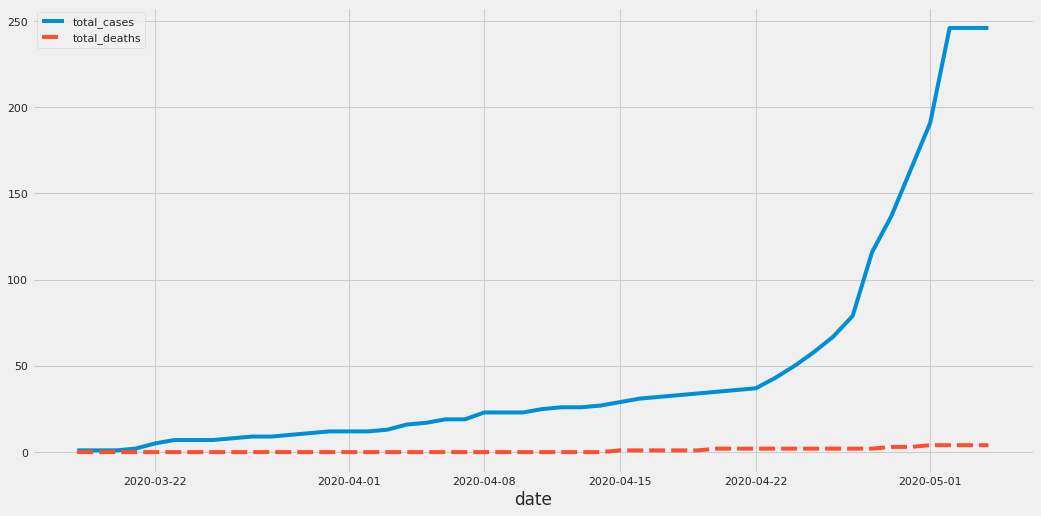

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

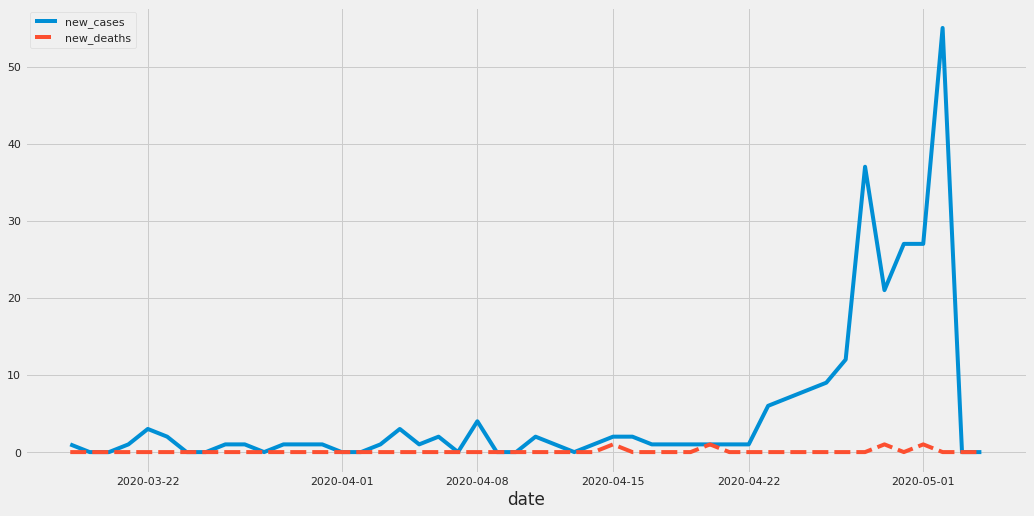

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-04-24 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-04-24 00:00:00, population_size=1572866.0, initially_infected=750.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-24,1.572116e+06,750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,750.000000,750.000000
2020-04-25,1.572116e+06,75.000000,0.000000,675.000000,675.000000,0.000000,0.000000,750.000000,750.000000
2020-04-26,1.571576e+06,547.242508,539.742508,540.000000,67.500000,202.500000,202.500000,1087.242508,1289.742508
2020-04-27,1.571145e+06,486.370013,431.645762,870.518257,492.518257,364.500000,162.000000,1356.888270,1721.388270
2020-04-28,1.570449e+06,744.289432,695.652430,1047.095792,437.733012,625.655477,261.155477,1791.385224,2417.040701


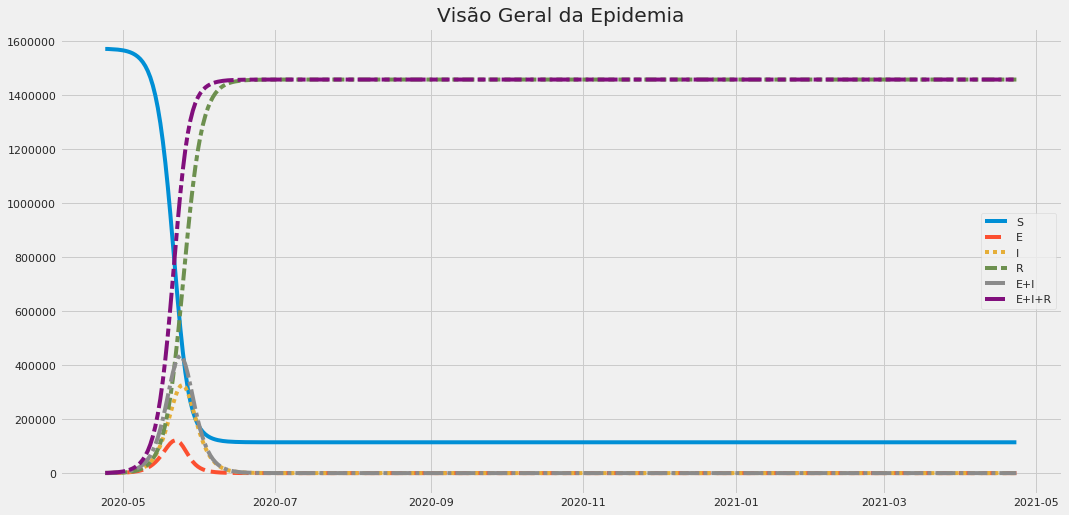

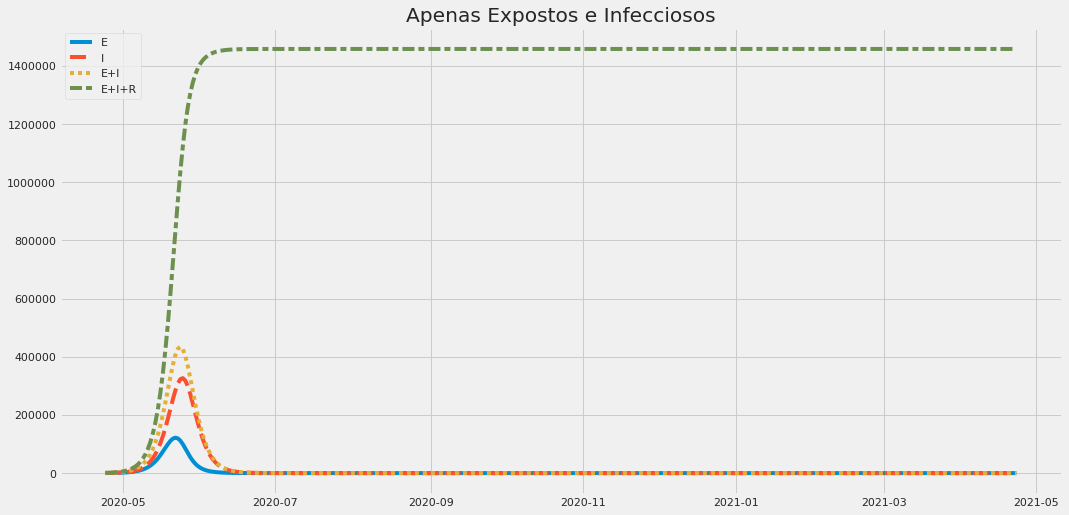

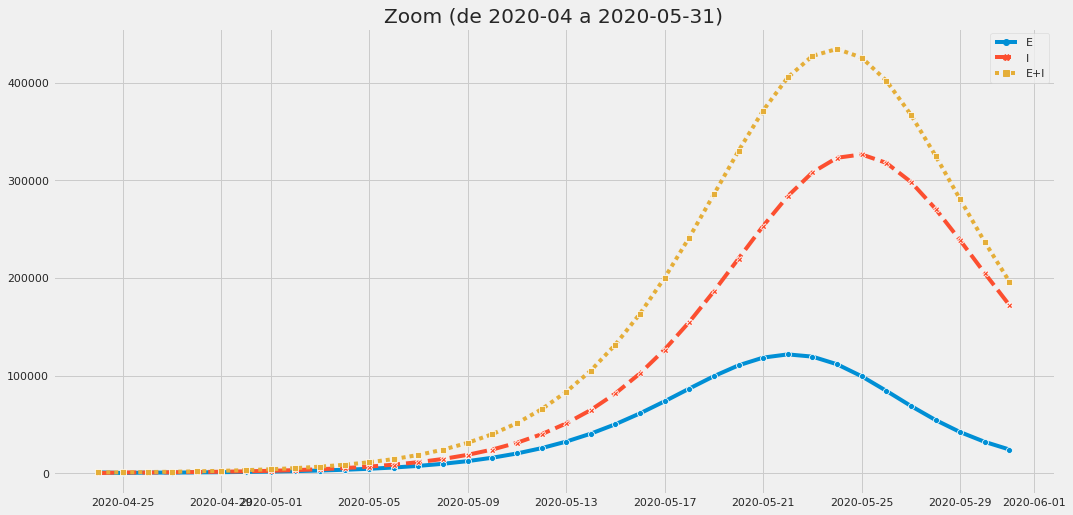

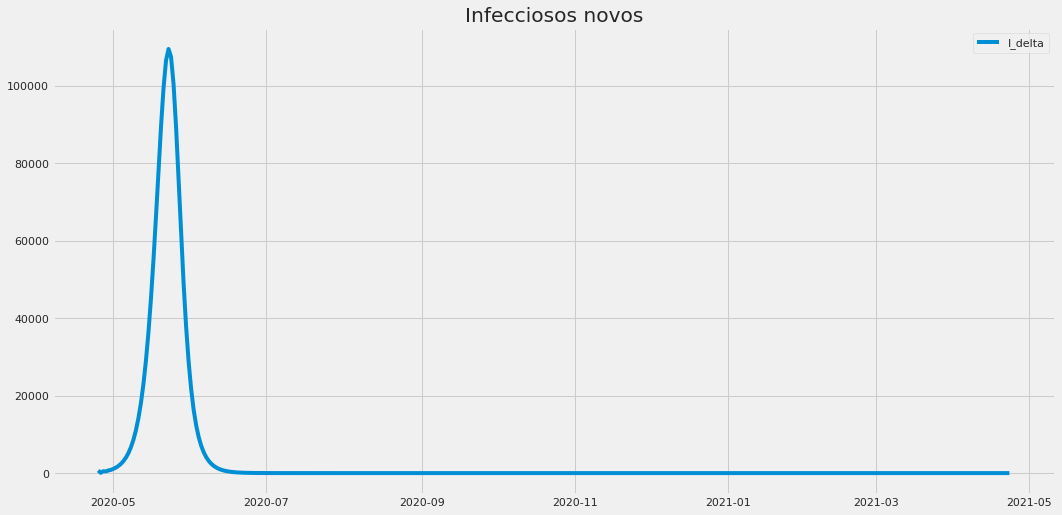

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

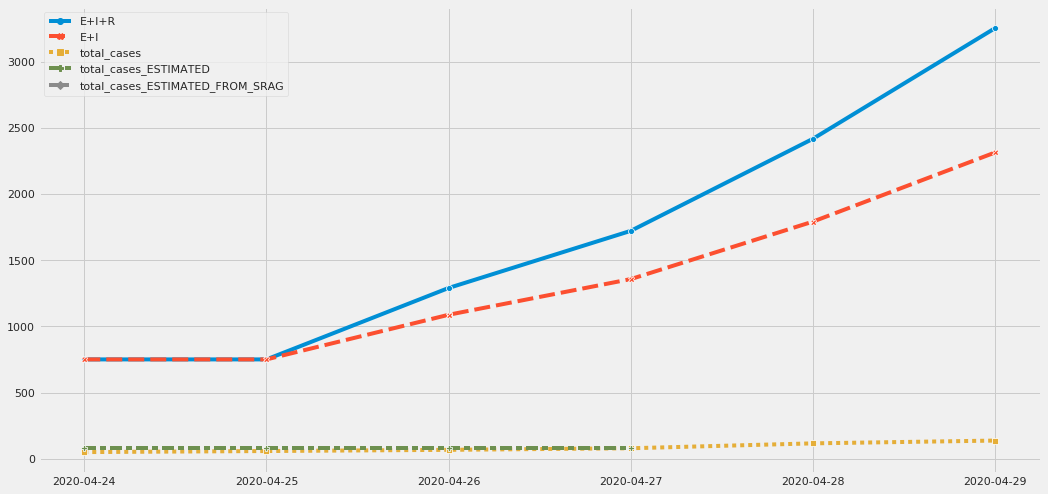

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-24,1.572116e+06,750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,750.000000,750.000000
2020-04-25,1.572116e+06,0.000000,0.000000,750.000000,750.000000,0.000000,0.000000,750.000000,750.000000
2020-04-26,1.571441e+06,674.678135,674.678135,450.000000,0.000000,300.000000,300.000000,1124.678135,1424.678135
2020-04-27,1.571037e+06,404.633157,404.633157,944.678135,674.678135,480.000000,180.000000,1349.311292,1829.311292
2020-04-28,1.570187e+06,849.221490,849.221490,971.440038,404.633157,857.871254,377.871254,1820.661529,2678.532783


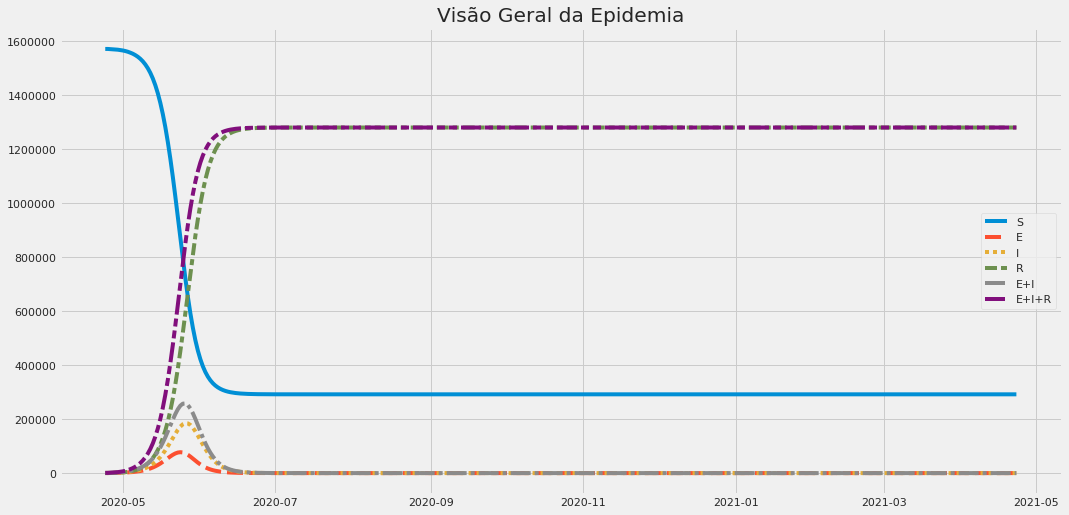

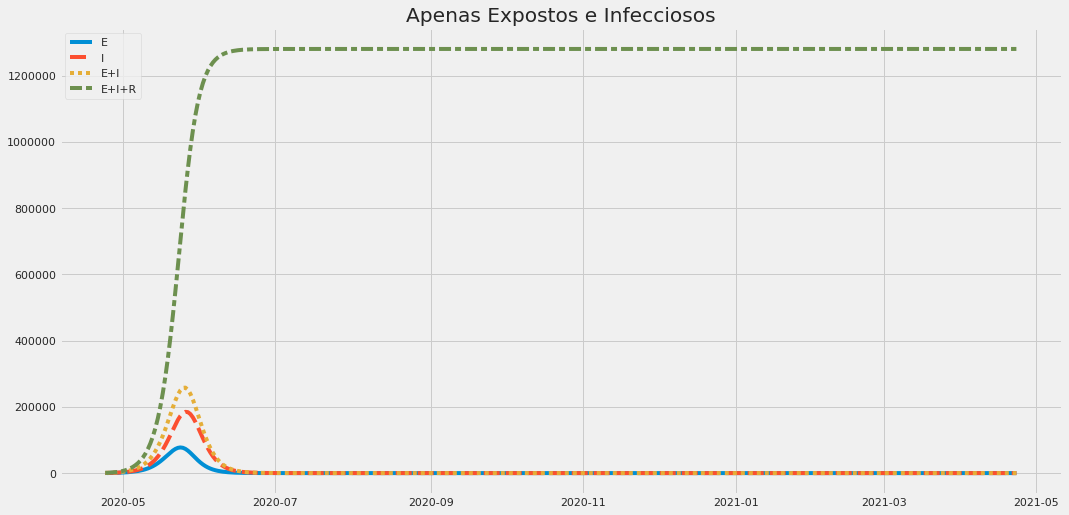

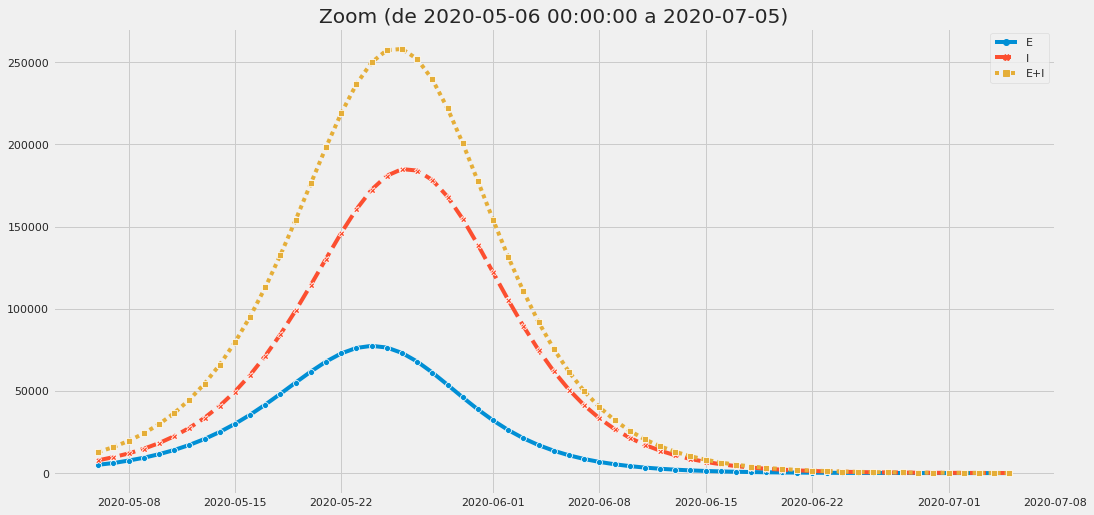

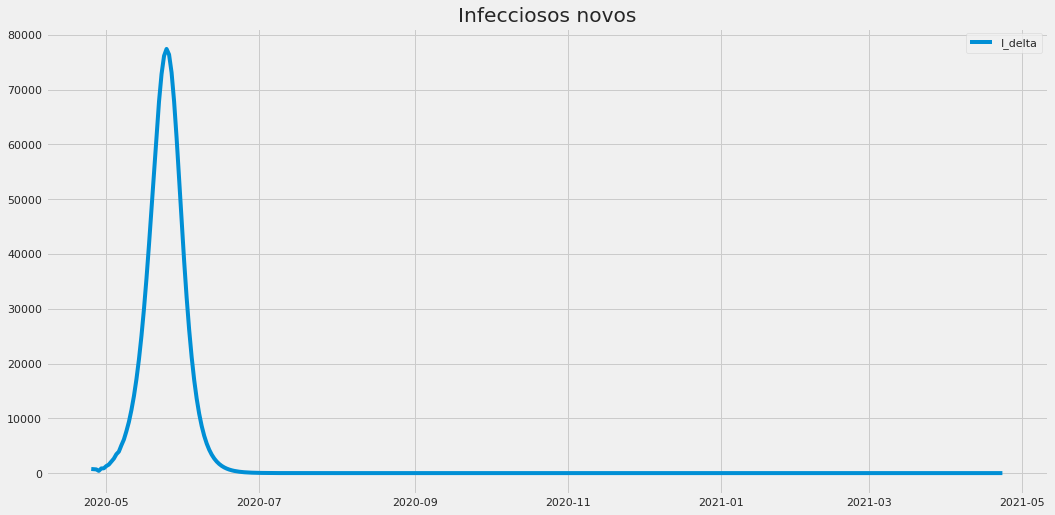

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

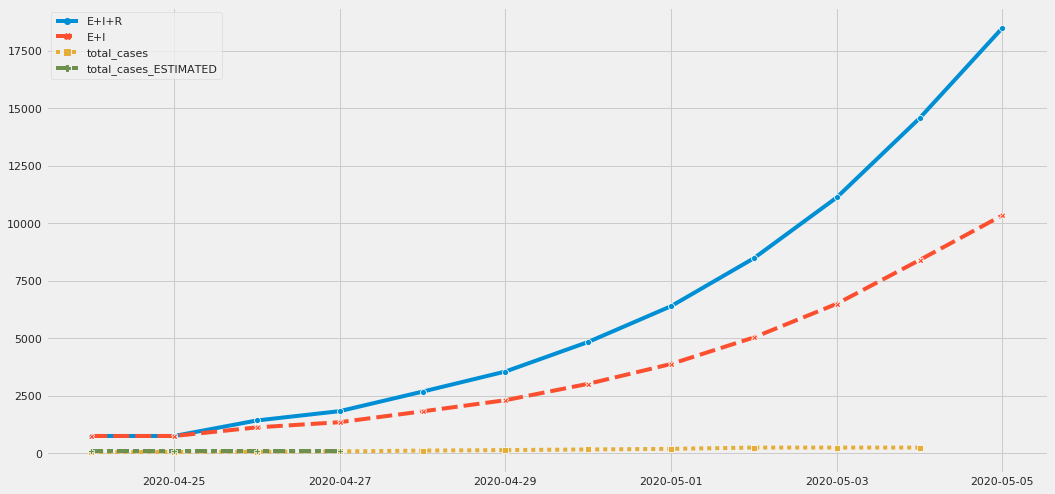

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|          | 12/1000 [00:00<00:08, 118.42trial/s, best loss: 213.63763970929912]

  2%|▏         | 24/1000 [00:00<00:08, 116.33trial/s, best loss: 201.32517643921486]

  3%|▎         | 32/1000 [00:00<00:09, 101.02trial/s, best loss: 201.32517643921486]

  4%|▍         | 42/1000 [00:00<00:09, 97.56trial/s, best loss: 201.32517643921486] 

  5%|▌         | 51/1000 [00:00<00:10, 93.79trial/s, best loss: 201.32517643921486]

  6%|▌         | 60/1000 [00:00<00:10, 91.25trial/s, best loss: 201.32517643921486]

  7%|▋         | 68/1000 [00:00<00:10, 87.10trial/s, best loss: 201.32517643921486]

  8%|▊         | 76/1000 [00:00<00:11, 79.23trial/s, best loss: 201.32517643921486]

  8%|▊         | 84/1000 [00:00<00:12, 72.84trial/s, best loss: 180.52052159631106]

  9%|▉         | 93/1000 [00:01<00:11, 76.72trial/s, best loss: 174.2282903711113] 

 10%|█         | 102/1000 [00:01<00:11, 79.05trial/s, best loss: 174.2282903711113]

 11%|█         | 110/1000 [00:01<00:11, 74.80trial/s, best loss: 174.2282903711113]

 12%|█▏        | 119/1000 [00:01<00:11, 76.34trial/s, best loss: 174.2282903711113]

 13%|█▎        | 128/1000 [00:01<00:11, 78.27trial/s, best loss: 174.2282903711113]

 14%|█▎        | 137/1000 [00:01<00:10, 79.10trial/s, best loss: 174.2282903711113]

 14%|█▍        | 145/1000 [00:01<00:10, 78.81trial/s, best loss: 174.2282903711113]

 15%|█▌        | 154/1000 [00:01<00:10, 80.21trial/s, best loss: 174.2282903711113]

 16%|█▋        | 163/1000 [00:01<00:10, 81.15trial/s, best loss: 164.25842271304688]

 17%|█▋        | 172/1000 [00:02<00:10, 76.77trial/s, best loss: 164.25842271304688]

 18%|█▊        | 180/1000 [00:02<00:11, 72.81trial/s, best loss: 164.25842271304688]

 19%|█▉        | 188/1000 [00:02<00:11, 69.40trial/s, best loss: 150.91633161257752]

 20%|█▉        | 196/1000 [00:02<00:11, 71.11trial/s, best loss: 150.91633161257752]

 20%|██        | 204/1000 [00:02<00:11, 69.10trial/s, best loss: 150.91633161257752]

 21%|██        | 212/1000 [00:02<00:11, 70.38trial/s, best loss: 150.91633161257752]

 22%|██▏       | 220/1000 [00:02<00:10, 71.48trial/s, best loss: 150.91633161257752]

 23%|██▎       | 228/1000 [00:02<00:10, 71.84trial/s, best loss: 150.91633161257752]

 24%|██▎       | 236/1000 [00:03<00:10, 72.35trial/s, best loss: 150.91633161257752]

 24%|██▍       | 244/1000 [00:03<00:10, 72.92trial/s, best loss: 150.91633161257752]

 25%|██▌       | 252/1000 [00:03<00:10, 72.16trial/s, best loss: 150.91633161257752]

 26%|██▌       | 260/1000 [00:03<00:10, 68.34trial/s, best loss: 147.50604714479192]

 27%|██▋       | 268/1000 [00:03<00:10, 69.80trial/s, best loss: 145.37185117890243]

 28%|██▊       | 276/1000 [00:03<00:10, 70.77trial/s, best loss: 136.93928689893866]

 28%|██▊       | 284/1000 [00:03<00:10, 70.25trial/s, best loss: 136.93928689893866]

 29%|██▉       | 292/1000 [00:03<00:10, 70.01trial/s, best loss: 136.93928689893866]

 30%|███       | 300/1000 [00:03<00:10, 63.87trial/s, best loss: 136.93928689893866]

 31%|███       | 308/1000 [00:04<00:10, 65.97trial/s, best loss: 136.93928689893866]

 32%|███▏      | 316/1000 [00:04<00:10, 67.15trial/s, best loss: 136.93928689893866]

 32%|███▏      | 323/1000 [00:04<00:10, 67.38trial/s, best loss: 136.93928689893866]

 33%|███▎      | 331/1000 [00:04<00:09, 69.20trial/s, best loss: 136.93928689893866]

 34%|███▍      | 339/1000 [00:04<00:09, 70.19trial/s, best loss: 136.93928689893866]

 35%|███▍      | 347/1000 [00:04<00:09, 70.60trial/s, best loss: 136.93928689893866]

 36%|███▌      | 355/1000 [00:04<00:09, 69.14trial/s, best loss: 136.93928689893866]

 36%|███▌      | 362/1000 [00:04<00:09, 69.24trial/s, best loss: 136.93928689893866]

 37%|███▋      | 369/1000 [00:04<00:09, 68.98trial/s, best loss: 136.93928689893866]

 38%|███▊      | 376/1000 [00:05<00:09, 68.61trial/s, best loss: 136.93928689893866]

 38%|███▊      | 383/1000 [00:05<00:10, 59.94trial/s, best loss: 136.93928689893866]

 39%|███▉      | 390/1000 [00:05<00:10, 59.95trial/s, best loss: 136.93928689893866]

 40%|███▉      | 397/1000 [00:05<00:09, 62.00trial/s, best loss: 136.93928689893866]

 40%|████      | 404/1000 [00:05<00:09, 63.59trial/s, best loss: 136.93928689893866]

 41%|████      | 411/1000 [00:05<00:09, 64.34trial/s, best loss: 136.93928689893866]

 42%|████▏     | 418/1000 [00:05<00:09, 62.67trial/s, best loss: 136.93928689893866]

 42%|████▎     | 425/1000 [00:05<00:08, 64.22trial/s, best loss: 136.93928689893866]

 43%|████▎     | 432/1000 [00:05<00:08, 65.17trial/s, best loss: 136.93928689893866]

 44%|████▍     | 439/1000 [00:06<00:08, 65.51trial/s, best loss: 136.93928689893866]

 45%|████▍     | 446/1000 [00:06<00:08, 65.87trial/s, best loss: 136.93928689893866]

 45%|████▌     | 453/1000 [00:06<00:08, 62.96trial/s, best loss: 136.93928689893866]

 46%|████▌     | 460/1000 [00:06<00:08, 63.73trial/s, best loss: 136.93928689893866]

 47%|████▋     | 467/1000 [00:06<00:08, 63.16trial/s, best loss: 136.93928689893866]

 47%|████▋     | 474/1000 [00:06<00:08, 61.23trial/s, best loss: 136.93928689893866]

 48%|████▊     | 481/1000 [00:06<00:09, 56.42trial/s, best loss: 136.93928689893866]

 49%|████▉     | 488/1000 [00:06<00:08, 58.69trial/s, best loss: 136.93928689893866]

 50%|████▉     | 495/1000 [00:06<00:08, 60.46trial/s, best loss: 136.93928689893866]

 50%|█████     | 502/1000 [00:07<00:08, 61.55trial/s, best loss: 136.93928689893866]

 51%|█████     | 509/1000 [00:07<00:07, 62.36trial/s, best loss: 136.93928689893866]

 52%|█████▏    | 516/1000 [00:07<00:07, 60.58trial/s, best loss: 136.93928689893866]

 52%|█████▏    | 523/1000 [00:07<00:07, 61.34trial/s, best loss: 136.93928689893866]

 53%|█████▎    | 530/1000 [00:07<00:07, 61.80trial/s, best loss: 136.93928689893866]

 54%|█████▎    | 537/1000 [00:07<00:07, 61.39trial/s, best loss: 136.93928689893866]

 54%|█████▍    | 544/1000 [00:07<00:07, 61.50trial/s, best loss: 136.93928689893866]

 55%|█████▌    | 551/1000 [00:07<00:07, 61.67trial/s, best loss: 136.93928689893866]

 56%|█████▌    | 558/1000 [00:08<00:07, 61.90trial/s, best loss: 136.93928689893866]

 56%|█████▋    | 565/1000 [00:08<00:06, 62.21trial/s, best loss: 136.93928689893866]

 57%|█████▋    | 572/1000 [00:08<00:07, 59.58trial/s, best loss: 136.93928689893866]

 58%|█████▊    | 578/1000 [00:08<00:07, 59.62trial/s, best loss: 136.93928689893866]

 58%|█████▊    | 584/1000 [00:08<00:07, 59.36trial/s, best loss: 136.93928689893866]

 59%|█████▉    | 591/1000 [00:08<00:06, 59.11trial/s, best loss: 136.93928689893866]

 60%|█████▉    | 597/1000 [00:08<00:07, 56.58trial/s, best loss: 136.93928689893866]

 60%|██████    | 604/1000 [00:08<00:06, 57.66trial/s, best loss: 136.93928689893866]

 61%|██████    | 610/1000 [00:08<00:06, 58.09trial/s, best loss: 136.93928689893866]

 62%|██████▏   | 617/1000 [00:09<00:06, 58.87trial/s, best loss: 136.93928689893866]

 62%|██████▏   | 624/1000 [00:09<00:06, 59.30trial/s, best loss: 134.93107986876433]

 63%|██████▎   | 630/1000 [00:09<00:06, 58.49trial/s, best loss: 134.93107986876433]

 64%|██████▎   | 636/1000 [00:09<00:06, 58.37trial/s, best loss: 134.93107986876433]

 64%|██████▍   | 642/1000 [00:09<00:06, 58.83trial/s, best loss: 134.93107986876433]

 65%|██████▍   | 648/1000 [00:09<00:05, 58.80trial/s, best loss: 134.93107986876433]

 65%|██████▌   | 654/1000 [00:09<00:05, 58.07trial/s, best loss: 134.93107986876433]

 66%|██████▌   | 660/1000 [00:09<00:05, 57.88trial/s, best loss: 134.93107986876433]

 67%|██████▋   | 666/1000 [00:09<00:05, 58.22trial/s, best loss: 134.93107986876433]

 67%|██████▋   | 672/1000 [00:09<00:05, 58.36trial/s, best loss: 134.93107986876433]

 68%|██████▊   | 678/1000 [00:10<00:05, 58.52trial/s, best loss: 134.93107986876433]

 68%|██████▊   | 684/1000 [00:10<00:05, 57.94trial/s, best loss: 134.93107986876433]

 69%|██████▉   | 690/1000 [00:10<00:05, 54.75trial/s, best loss: 134.93107986876433]

 70%|██████▉   | 696/1000 [00:10<00:05, 54.80trial/s, best loss: 134.93107986876433]

 70%|███████   | 702/1000 [00:10<00:05, 55.07trial/s, best loss: 134.93107986876433]

 71%|███████   | 708/1000 [00:10<00:05, 55.29trial/s, best loss: 134.93107986876433]

 71%|███████▏  | 714/1000 [00:10<00:05, 53.87trial/s, best loss: 134.93107986876433]

 72%|███████▏  | 720/1000 [00:10<00:05, 54.27trial/s, best loss: 134.93107986876433]

 73%|███████▎  | 726/1000 [00:11<00:05, 48.96trial/s, best loss: 134.93107986876433]

 73%|███████▎  | 732/1000 [00:11<00:05, 50.94trial/s, best loss: 134.93107986876433]

 74%|███████▍  | 738/1000 [00:11<00:05, 52.08trial/s, best loss: 134.93107986876433]

 74%|███████▍  | 744/1000 [00:11<00:04, 51.74trial/s, best loss: 134.93107986876433]

 75%|███████▌  | 750/1000 [00:11<00:04, 52.83trial/s, best loss: 134.93107986876433]

 76%|███████▌  | 756/1000 [00:11<00:04, 53.93trial/s, best loss: 134.93107986876433]

 76%|███████▌  | 762/1000 [00:11<00:04, 54.10trial/s, best loss: 134.93107986876433]

 77%|███████▋  | 768/1000 [00:11<00:04, 53.11trial/s, best loss: 134.93107986876433]

 77%|███████▋  | 774/1000 [00:11<00:04, 53.68trial/s, best loss: 134.93107986876433]

 78%|███████▊  | 780/1000 [00:11<00:04, 54.51trial/s, best loss: 134.93107986876433]

 79%|███████▊  | 786/1000 [00:12<00:03, 54.71trial/s, best loss: 134.93107986876433]

 79%|███████▉  | 792/1000 [00:12<00:03, 54.99trial/s, best loss: 134.93107986876433]

 80%|███████▉  | 798/1000 [00:12<00:03, 52.63trial/s, best loss: 134.93107986876433]

 80%|████████  | 804/1000 [00:12<00:03, 53.34trial/s, best loss: 134.93107986876433]

 81%|████████  | 810/1000 [00:12<00:03, 53.96trial/s, best loss: 134.93107986876433]

 82%|████████▏ | 816/1000 [00:12<00:03, 53.47trial/s, best loss: 134.93107986876433]

 82%|████████▏ | 822/1000 [00:12<00:03, 53.88trial/s, best loss: 134.93107986876433]

 83%|████████▎ | 828/1000 [00:12<00:03, 54.08trial/s, best loss: 134.93107986876433]

 83%|████████▎ | 834/1000 [00:12<00:03, 54.46trial/s, best loss: 134.93107986876433]

 84%|████████▍ | 840/1000 [00:13<00:02, 54.47trial/s, best loss: 134.93107986876433]

 85%|████████▍ | 846/1000 [00:13<00:03, 46.58trial/s, best loss: 134.93107986876433]

 85%|████████▌ | 852/1000 [00:13<00:03, 47.83trial/s, best loss: 134.93107986876433]

 86%|████████▌ | 858/1000 [00:13<00:02, 48.98trial/s, best loss: 134.93107986876433]

 86%|████████▋ | 864/1000 [00:13<00:02, 49.82trial/s, best loss: 134.93107986876433]

 87%|████████▋ | 870/1000 [00:13<00:02, 49.76trial/s, best loss: 134.93107986876433]

 88%|████████▊ | 876/1000 [00:13<00:02, 50.48trial/s, best loss: 134.93107986876433]

 88%|████████▊ | 882/1000 [00:13<00:02, 51.13trial/s, best loss: 134.93107986876433]

 89%|████████▉ | 888/1000 [00:14<00:02, 51.24trial/s, best loss: 134.93107986876433]

 89%|████████▉ | 894/1000 [00:14<00:02, 50.41trial/s, best loss: 134.93107986876433]

 90%|█████████ | 900/1000 [00:14<00:02, 45.26trial/s, best loss: 134.93107986876433]

 91%|█████████ | 906/1000 [00:14<00:01, 47.14trial/s, best loss: 134.93107986876433]

 91%|█████████ | 912/1000 [00:14<00:01, 48.59trial/s, best loss: 134.93107986876433]

 92%|█████████▏| 918/1000 [00:14<00:01, 49.18trial/s, best loss: 134.93107986876433]

 92%|█████████▏| 924/1000 [00:14<00:01, 50.22trial/s, best loss: 134.93107986876433]

 93%|█████████▎| 930/1000 [00:14<00:01, 50.58trial/s, best loss: 134.93107986876433]

 94%|█████████▎| 936/1000 [00:15<00:01, 50.96trial/s, best loss: 134.93107986876433]

 94%|█████████▍| 942/1000 [00:15<00:01, 51.04trial/s, best loss: 134.93107986876433]

 95%|█████████▍| 948/1000 [00:15<00:01, 50.22trial/s, best loss: 134.93107986876433]

 95%|█████████▌| 954/1000 [00:15<00:00, 49.54trial/s, best loss: 134.93107986876433]

 96%|█████████▌| 959/1000 [00:15<00:00, 49.57trial/s, best loss: 134.93107986876433]

 96%|█████████▋| 965/1000 [00:15<00:00, 49.24trial/s, best loss: 134.93107986876433]

 97%|█████████▋| 970/1000 [00:15<00:00, 48.48trial/s, best loss: 134.93107986876433]

 98%|█████████▊| 975/1000 [00:15<00:00, 48.88trial/s, best loss: 134.93107986876433]

 98%|█████████▊| 980/1000 [00:15<00:00, 48.89trial/s, best loss: 134.93107986876433]

 98%|█████████▊| 985/1000 [00:16<00:00, 48.99trial/s, best loss: 134.93107986876433]

 99%|█████████▉| 991/1000 [00:16<00:00, 49.46trial/s, best loss: 134.93107986876433]

100%|█████████▉| 996/1000 [00:16<00:00, 47.31trial/s, best loss: 134.93107986876433]

100%|██████████| 1000/1000 [00:16<00:00, 60.84trial/s, best loss: 134.93107986876433]


Best parameters found: {'alpha': 0.9931351676168763, 'beta': 0.5486349828612915, 'gamma': 0.44197659143480256}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-24,1.572116e+06,750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,750.000000,750.000000
2020-04-25,1.572116e+06,5.148624,0.000000,744.851376,744.851376,0.000000,0.000000,750.000000,750.000000
2020-04-26,1.571708e+06,408.492006,408.456662,420.757783,5.113280,329.206872,329.206872,829.249790,1158.456662
2020-04-27,1.571477e+06,233.476647,230.672418,640.480470,405.687777,515.171963,185.965091,873.957117,1389.129080
2020-04-28,1.571126e+06,352.682428,351.079650,589.276964,231.873869,798.249338,283.077375,941.959391,1740.208729


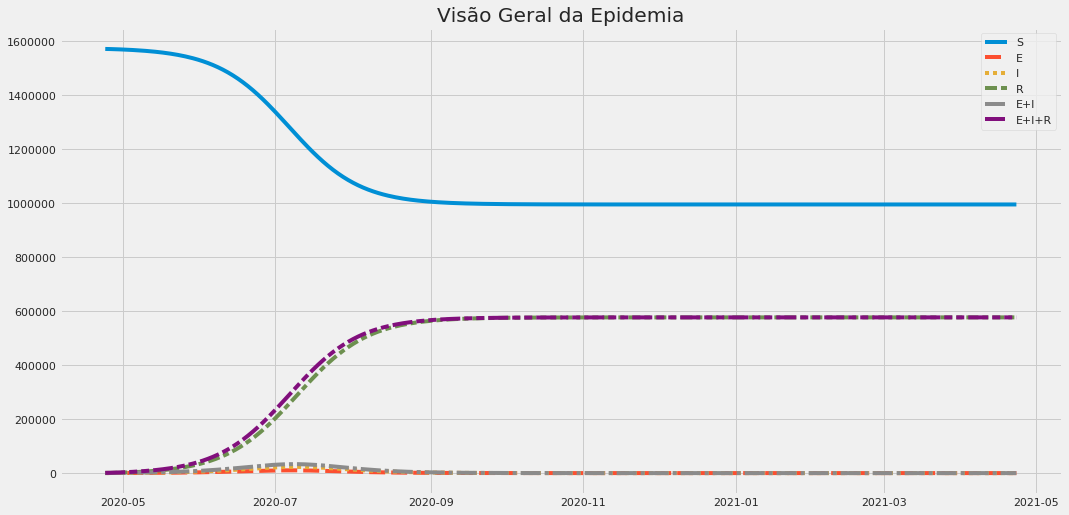

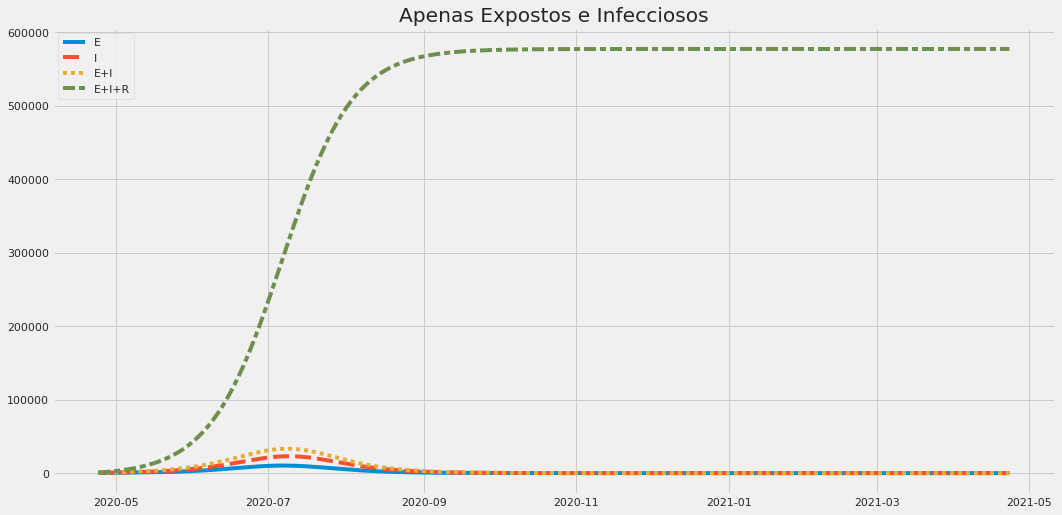

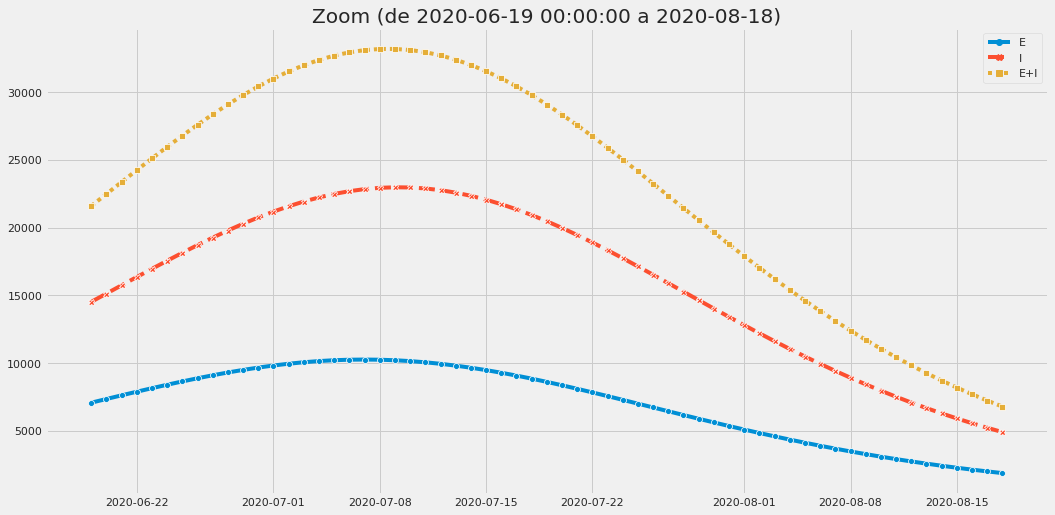

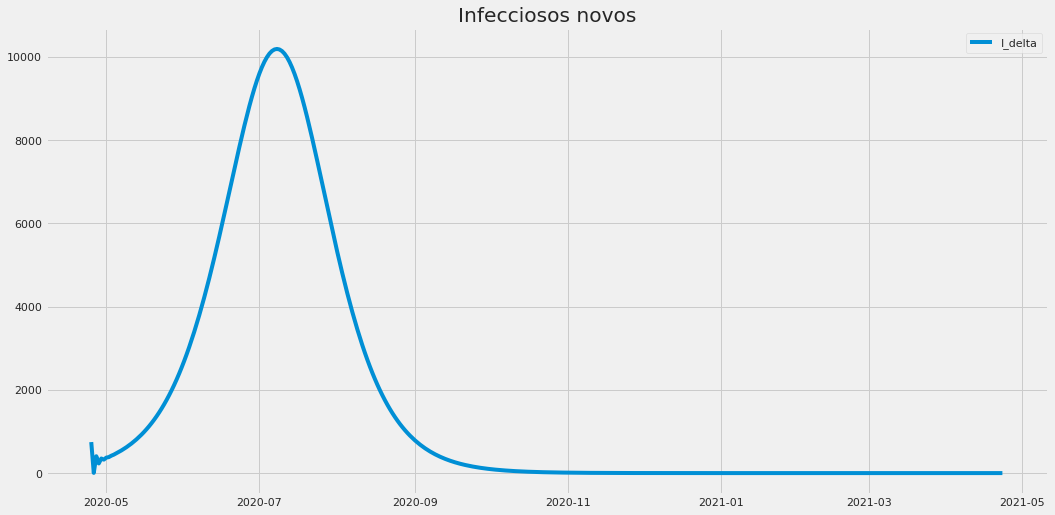

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,27,0,164,3,1572866.0,NaN,2460,NaN
2020-05-01,27,1,191,4,1572866.0,NaN,2865,NaN
2020-05-02,55,0,246,4,1572866.0,NaN,3690,NaN
2020-05-03,0,0,246,4,1572866.0,NaN,3690,NaN
2020-05-04,0,0,246,4,1572866.0,NaN,3690,NaN


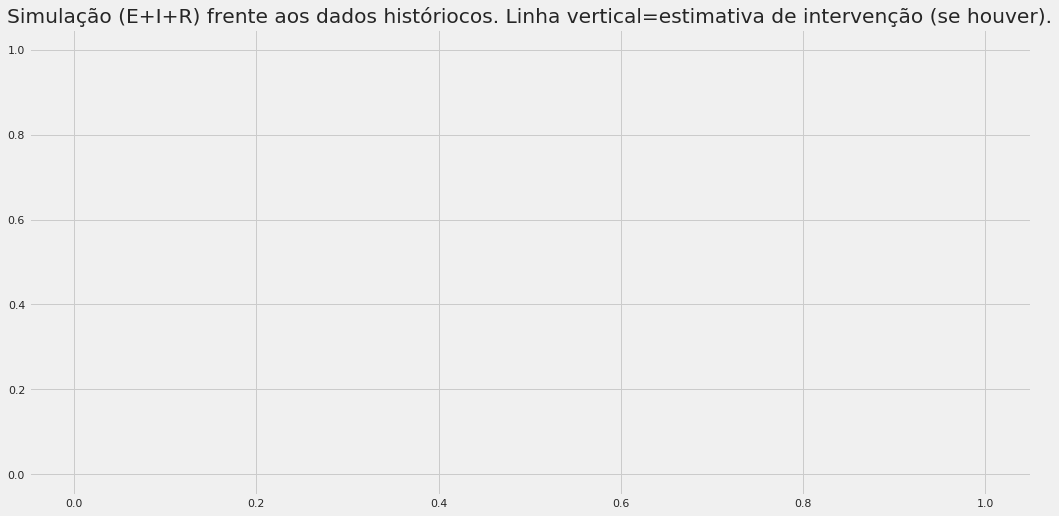

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 9/3000 [00:00<00:33, 89.10trial/s, best loss: 217.09352611466286]

  1%|          | 19/3000 [00:00<00:32, 91.04trial/s, best loss: 158.5125958835737]

  1%|          | 25/3000 [00:00<00:38, 76.88trial/s, best loss: 158.5125958835737]

  1%|          | 31/3000 [00:00<00:44, 67.15trial/s, best loss: 158.5125958835737]

  1%|          | 37/3000 [00:00<00:56, 52.21trial/s, best loss: 158.5125958835737]

  1%|▏         | 42/3000 [00:00<00:59, 49.70trial/s, best loss: 158.5125958835737]

  2%|▏         | 47/3000 [00:00<00:59, 49.50trial/s, best loss: 158.5125958835737]

  2%|▏         | 52/3000 [00:00<00:59, 49.32trial/s, best loss: 158.5125958835737]

  2%|▏         | 57/3000 [00:01<01:00, 48.30trial/s, best loss: 158.5125958835737]

  2%|▏         | 62/3000 [00:01<01:01, 47.45trial/s, best loss: 158.5125958835737]

  2%|▏         | 67/3000 [00:01<01:01, 47.50trial/s, best loss: 146.5581927962833]

  2%|▏         | 72/3000 [00:01<01:02, 47.17trial/s, best loss: 146.5581927962833]

  3%|▎         | 77/3000 [00:01<01:01, 47.25trial/s, best loss: 146.5581927962833]

  3%|▎         | 82/3000 [00:01<01:01, 47.08trial/s, best loss: 146.5581927962833]

  3%|▎         | 87/3000 [00:01<01:03, 46.11trial/s, best loss: 146.5581927962833]

  3%|▎         | 92/3000 [00:01<01:02, 46.29trial/s, best loss: 146.5581927962833]

  3%|▎         | 97/3000 [00:01<01:02, 46.59trial/s, best loss: 146.5581927962833]

  3%|▎         | 102/3000 [00:01<01:02, 46.54trial/s, best loss: 146.5581927962833]

  4%|▎         | 107/3000 [00:02<01:10, 41.17trial/s, best loss: 146.5581927962833]

  4%|▎         | 112/3000 [00:02<01:07, 42.48trial/s, best loss: 146.5581927962833]

  4%|▍         | 117/3000 [00:02<01:06, 43.06trial/s, best loss: 146.5581927962833]

  4%|▍         | 122/3000 [00:02<01:05, 43.99trial/s, best loss: 146.5581927962833]

  4%|▍         | 127/3000 [00:02<01:04, 44.21trial/s, best loss: 146.5581927962833]

  4%|▍         | 132/3000 [00:02<01:05, 43.61trial/s, best loss: 146.5581927962833]

  5%|▍         | 137/3000 [00:02<01:06, 43.21trial/s, best loss: 146.5581927962833]

  5%|▍         | 142/3000 [00:02<01:05, 43.65trial/s, best loss: 146.5581927962833]

  5%|▍         | 147/3000 [00:03<01:06, 43.22trial/s, best loss: 146.5581927962833]

  5%|▌         | 152/3000 [00:03<01:06, 43.01trial/s, best loss: 139.9317003760084]

  5%|▌         | 157/3000 [00:03<01:05, 43.16trial/s, best loss: 139.9317003760084]

  5%|▌         | 162/3000 [00:03<01:11, 39.66trial/s, best loss: 139.9317003760084]

  6%|▌         | 167/3000 [00:03<01:10, 39.91trial/s, best loss: 139.9317003760084]

  6%|▌         | 172/3000 [00:03<01:12, 38.77trial/s, best loss: 139.9317003760084]

  6%|▌         | 177/3000 [00:03<01:10, 39.93trial/s, best loss: 139.9317003760084]

  6%|▌         | 182/3000 [00:03<01:10, 39.90trial/s, best loss: 139.9317003760084]

  6%|▌         | 187/3000 [00:04<01:11, 39.39trial/s, best loss: 139.9317003760084]

  6%|▋         | 192/3000 [00:04<01:10, 39.81trial/s, best loss: 139.9317003760084]

  7%|▋         | 197/3000 [00:04<01:09, 40.40trial/s, best loss: 139.9317003760084]

  7%|▋         | 202/3000 [00:04<01:15, 36.82trial/s, best loss: 139.9317003760084]

  7%|▋         | 207/3000 [00:04<01:13, 37.82trial/s, best loss: 139.9317003760084]

  7%|▋         | 211/3000 [00:04<01:14, 37.53trial/s, best loss: 139.9317003760084]

  7%|▋         | 216/3000 [00:04<01:12, 38.56trial/s, best loss: 139.9317003760084]

  7%|▋         | 221/3000 [00:04<01:10, 39.38trial/s, best loss: 139.9317003760084]

  8%|▊         | 225/3000 [00:05<01:10, 39.33trial/s, best loss: 139.9317003760084]

  8%|▊         | 230/3000 [00:05<01:09, 39.67trial/s, best loss: 139.9317003760084]

  8%|▊         | 235/3000 [00:05<01:09, 40.06trial/s, best loss: 139.9317003760084]

  8%|▊         | 240/3000 [00:05<01:08, 40.43trial/s, best loss: 139.9317003760084]

  8%|▊         | 245/3000 [00:05<01:08, 40.39trial/s, best loss: 139.9317003760084]

  8%|▊         | 250/3000 [00:05<01:15, 36.44trial/s, best loss: 139.9317003760084]

  8%|▊         | 254/3000 [00:05<01:13, 37.21trial/s, best loss: 139.9317003760084]

  9%|▊         | 258/3000 [00:05<01:12, 37.82trial/s, best loss: 139.9317003760084]

  9%|▊         | 262/3000 [00:06<01:11, 38.42trial/s, best loss: 139.9317003760084]

  9%|▉         | 266/3000 [00:06<01:12, 37.92trial/s, best loss: 139.9317003760084]

  9%|▉         | 270/3000 [00:06<01:11, 38.31trial/s, best loss: 139.9317003760084]

  9%|▉         | 274/3000 [00:06<01:11, 38.32trial/s, best loss: 139.9317003760084]

  9%|▉         | 278/3000 [00:06<01:10, 38.69trial/s, best loss: 139.9317003760084]

  9%|▉         | 282/3000 [00:06<01:09, 38.92trial/s, best loss: 139.9317003760084]

 10%|▉         | 286/3000 [00:06<01:12, 37.46trial/s, best loss: 139.9317003760084]

 10%|▉         | 290/3000 [00:06<01:11, 37.92trial/s, best loss: 139.9317003760084]

 10%|▉         | 294/3000 [00:06<01:10, 38.15trial/s, best loss: 139.9317003760084]

 10%|▉         | 298/3000 [00:06<01:10, 38.22trial/s, best loss: 139.9317003760084]

 10%|█         | 302/3000 [00:07<01:11, 37.78trial/s, best loss: 139.9317003760084]

 10%|█         | 306/3000 [00:07<01:11, 37.86trial/s, best loss: 139.9317003760084]

 10%|█         | 310/3000 [00:07<01:10, 37.94trial/s, best loss: 139.9317003760084]

 10%|█         | 314/3000 [00:07<01:10, 37.90trial/s, best loss: 139.9317003760084]

 11%|█         | 318/3000 [00:07<01:11, 37.64trial/s, best loss: 139.9317003760084]

 11%|█         | 322/3000 [00:07<01:13, 36.66trial/s, best loss: 139.9317003760084]

 11%|█         | 326/3000 [00:07<01:13, 36.56trial/s, best loss: 139.9317003760084]

 11%|█         | 330/3000 [00:07<01:12, 36.97trial/s, best loss: 139.9317003760084]

 11%|█         | 334/3000 [00:07<01:15, 35.31trial/s, best loss: 139.9317003760084]

 11%|█▏        | 338/3000 [00:08<01:23, 31.84trial/s, best loss: 139.9317003760084]

 11%|█▏        | 342/3000 [00:08<01:23, 31.70trial/s, best loss: 139.9317003760084]

 12%|█▏        | 346/3000 [00:08<01:21, 32.63trial/s, best loss: 139.9317003760084]

 12%|█▏        | 350/3000 [00:08<01:21, 32.62trial/s, best loss: 139.9317003760084]

 12%|█▏        | 354/3000 [00:08<01:21, 32.66trial/s, best loss: 139.9317003760084]

 12%|█▏        | 358/3000 [00:08<01:22, 31.91trial/s, best loss: 139.9317003760084]

 12%|█▏        | 362/3000 [00:08<01:22, 31.83trial/s, best loss: 139.9317003760084]

 12%|█▏        | 366/3000 [00:09<01:31, 28.87trial/s, best loss: 139.9317003760084]

 12%|█▏        | 370/3000 [00:09<01:29, 29.44trial/s, best loss: 139.9317003760084]

 12%|█▏        | 374/3000 [00:09<01:27, 30.10trial/s, best loss: 139.9317003760084]

 13%|█▎        | 378/3000 [00:09<01:25, 30.55trial/s, best loss: 139.9317003760084]

 13%|█▎        | 382/3000 [00:09<01:26, 30.31trial/s, best loss: 139.9317003760084]

 13%|█▎        | 386/3000 [00:09<01:28, 29.51trial/s, best loss: 139.9317003760084]

 13%|█▎        | 390/3000 [00:09<01:26, 30.14trial/s, best loss: 139.9317003760084]

 13%|█▎        | 394/3000 [00:09<01:25, 30.54trial/s, best loss: 139.9317003760084]

 13%|█▎        | 398/3000 [00:10<01:25, 30.47trial/s, best loss: 139.9317003760084]

 13%|█▎        | 402/3000 [00:10<01:24, 30.57trial/s, best loss: 139.9317003760084]

 14%|█▎        | 406/3000 [00:10<01:24, 30.75trial/s, best loss: 139.9317003760084]

 14%|█▎        | 410/3000 [00:10<01:24, 30.63trial/s, best loss: 139.9317003760084]

 14%|█▍        | 414/3000 [00:10<01:24, 30.57trial/s, best loss: 139.9317003760084]

 14%|█▍        | 418/3000 [00:10<01:25, 30.05trial/s, best loss: 139.9317003760084]

 14%|█▍        | 422/3000 [00:10<01:26, 29.87trial/s, best loss: 139.9317003760084]

 14%|█▍        | 426/3000 [00:10<01:25, 30.02trial/s, best loss: 139.9317003760084]

 14%|█▍        | 430/3000 [00:11<01:26, 29.60trial/s, best loss: 139.9317003760084]

 14%|█▍        | 433/3000 [00:11<01:26, 29.66trial/s, best loss: 139.9317003760084]

 15%|█▍        | 436/3000 [00:11<01:37, 26.20trial/s, best loss: 139.9317003760084]

 15%|█▍        | 439/3000 [00:11<01:34, 27.14trial/s, best loss: 139.9317003760084]

 15%|█▍        | 442/3000 [00:11<01:32, 27.70trial/s, best loss: 139.9317003760084]

 15%|█▍        | 445/3000 [00:11<01:32, 27.54trial/s, best loss: 139.9317003760084]

 15%|█▍        | 448/3000 [00:11<01:31, 27.97trial/s, best loss: 139.9317003760084]

 15%|█▌        | 451/3000 [00:11<01:30, 28.24trial/s, best loss: 139.9317003760084]

 15%|█▌        | 454/3000 [00:12<01:29, 28.50trial/s, best loss: 139.9317003760084]

 15%|█▌        | 457/3000 [00:12<01:30, 28.14trial/s, best loss: 139.9317003760084]

 15%|█▌        | 460/3000 [00:12<01:29, 28.37trial/s, best loss: 139.9317003760084]

 15%|█▌        | 463/3000 [00:12<01:29, 28.38trial/s, best loss: 139.9317003760084]

 16%|█▌        | 466/3000 [00:12<01:28, 28.63trial/s, best loss: 139.9317003760084]

 16%|█▌        | 469/3000 [00:12<01:27, 28.79trial/s, best loss: 139.9317003760084]

 16%|█▌        | 472/3000 [00:12<01:33, 27.11trial/s, best loss: 139.9317003760084]

 16%|█▌        | 475/3000 [00:12<01:31, 27.58trial/s, best loss: 139.9317003760084]

 16%|█▌        | 478/3000 [00:12<01:33, 27.01trial/s, best loss: 139.9317003760084]

 16%|█▌        | 481/3000 [00:12<01:32, 27.19trial/s, best loss: 139.9317003760084]

 16%|█▌        | 484/3000 [00:13<01:32, 27.12trial/s, best loss: 139.9317003760084]

 16%|█▌        | 487/3000 [00:13<01:31, 27.38trial/s, best loss: 139.9317003760084]

 16%|█▋        | 490/3000 [00:13<01:30, 27.71trial/s, best loss: 139.9317003760084]

 16%|█▋        | 493/3000 [00:13<01:29, 28.05trial/s, best loss: 139.9317003760084]

 17%|█▋        | 496/3000 [00:13<01:28, 28.24trial/s, best loss: 139.9317003760084]

 17%|█▋        | 499/3000 [00:13<01:31, 27.32trial/s, best loss: 139.9317003760084]

 17%|█▋        | 502/3000 [00:13<01:31, 27.43trial/s, best loss: 138.741767121627] 

 17%|█▋        | 505/3000 [00:13<01:30, 27.49trial/s, best loss: 138.741767121627]

 17%|█▋        | 508/3000 [00:13<01:30, 27.49trial/s, best loss: 138.741767121627]

 17%|█▋        | 511/3000 [00:14<01:31, 27.19trial/s, best loss: 138.741767121627]

 17%|█▋        | 514/3000 [00:14<01:31, 27.18trial/s, best loss: 138.741767121627]

 17%|█▋        | 517/3000 [00:14<01:31, 27.23trial/s, best loss: 138.741767121627]

 17%|█▋        | 520/3000 [00:14<01:30, 27.32trial/s, best loss: 138.741767121627]

 17%|█▋        | 523/3000 [00:14<01:30, 27.44trial/s, best loss: 138.741767121627]

 18%|█▊        | 526/3000 [00:14<01:31, 27.03trial/s, best loss: 138.741767121627]

 18%|█▊        | 529/3000 [00:14<01:31, 27.15trial/s, best loss: 138.741767121627]

 18%|█▊        | 532/3000 [00:14<01:31, 27.04trial/s, best loss: 138.741767121627]

 18%|█▊        | 535/3000 [00:14<01:41, 24.23trial/s, best loss: 138.741767121627]

 18%|█▊        | 538/3000 [00:15<01:39, 24.77trial/s, best loss: 138.741767121627]

 18%|█▊        | 541/3000 [00:15<01:36, 25.51trial/s, best loss: 138.741767121627]

 18%|█▊        | 544/3000 [00:15<01:34, 25.95trial/s, best loss: 138.741767121627]

 18%|█▊        | 547/3000 [00:15<01:33, 26.32trial/s, best loss: 138.741767121627]

 18%|█▊        | 550/3000 [00:15<01:32, 26.55trial/s, best loss: 138.741767121627]

 18%|█▊        | 553/3000 [00:15<01:34, 25.97trial/s, best loss: 138.741767121627]

 19%|█▊        | 556/3000 [00:15<01:33, 26.20trial/s, best loss: 138.741767121627]

 19%|█▊        | 559/3000 [00:15<01:33, 26.17trial/s, best loss: 138.741767121627]

 19%|█▊        | 562/3000 [00:16<01:31, 26.52trial/s, best loss: 135.54923815750115]

 19%|█▉        | 565/3000 [00:16<01:33, 26.12trial/s, best loss: 135.54923815750115]

 19%|█▉        | 568/3000 [00:16<01:39, 24.37trial/s, best loss: 135.54923815750115]

 19%|█▉        | 571/3000 [00:16<01:36, 25.14trial/s, best loss: 135.54923815750115]

 19%|█▉        | 574/3000 [00:16<01:35, 25.53trial/s, best loss: 135.54923815750115]

 19%|█▉        | 577/3000 [00:16<01:35, 25.37trial/s, best loss: 135.54923815750115]

 19%|█▉        | 580/3000 [00:16<01:34, 25.51trial/s, best loss: 135.54923815750115]

 19%|█▉        | 583/3000 [00:16<01:41, 23.84trial/s, best loss: 135.54923815750115]

 20%|█▉        | 586/3000 [00:16<01:39, 24.35trial/s, best loss: 135.54923815750115]

 20%|█▉        | 589/3000 [00:17<01:39, 24.20trial/s, best loss: 135.54923815750115]

 20%|█▉        | 592/3000 [00:17<01:36, 24.83trial/s, best loss: 135.54923815750115]

 20%|█▉        | 595/3000 [00:17<01:35, 25.25trial/s, best loss: 135.54923815750115]

 20%|█▉        | 598/3000 [00:17<01:33, 25.64trial/s, best loss: 135.54923815750115]

 20%|██        | 601/3000 [00:17<01:41, 23.53trial/s, best loss: 135.54923815750115]

 20%|██        | 604/3000 [00:17<01:40, 23.84trial/s, best loss: 135.54923815750115]

 20%|██        | 607/3000 [00:17<01:38, 24.23trial/s, best loss: 135.54923815750115]

 20%|██        | 610/3000 [00:17<01:37, 24.56trial/s, best loss: 135.54923815750115]

 20%|██        | 613/3000 [00:18<01:38, 24.31trial/s, best loss: 135.54923815750115]

 21%|██        | 616/3000 [00:18<01:38, 24.31trial/s, best loss: 135.54923815750115]

 21%|██        | 619/3000 [00:18<01:36, 24.66trial/s, best loss: 135.54923815750115]

 21%|██        | 622/3000 [00:18<01:35, 24.95trial/s, best loss: 135.54923815750115]

 21%|██        | 625/3000 [00:18<01:34, 25.21trial/s, best loss: 135.54923815750115]

 21%|██        | 628/3000 [00:18<01:36, 24.62trial/s, best loss: 135.54923815750115]

 21%|██        | 631/3000 [00:18<01:35, 24.70trial/s, best loss: 135.54923815750115]

 21%|██        | 634/3000 [00:18<01:34, 24.94trial/s, best loss: 135.54923815750115]

 21%|██        | 637/3000 [00:19<01:34, 24.94trial/s, best loss: 135.54923815750115]

 21%|██▏       | 640/3000 [00:19<01:34, 25.07trial/s, best loss: 135.54923815750115]

 21%|██▏       | 643/3000 [00:19<01:33, 25.25trial/s, best loss: 135.54923815750115]

 22%|██▏       | 646/3000 [00:19<01:32, 25.50trial/s, best loss: 135.54923815750115]

 22%|██▏       | 649/3000 [00:19<01:33, 25.17trial/s, best loss: 135.54923815750115]

 22%|██▏       | 652/3000 [00:19<01:37, 24.07trial/s, best loss: 135.54923815750115]

 22%|██▏       | 655/3000 [00:19<01:36, 24.29trial/s, best loss: 135.54923815750115]

 22%|██▏       | 658/3000 [00:19<01:35, 24.54trial/s, best loss: 135.54923815750115]

 22%|██▏       | 661/3000 [00:20<01:34, 24.64trial/s, best loss: 135.54923815750115]

 22%|██▏       | 664/3000 [00:20<01:35, 24.54trial/s, best loss: 135.54923815750115]

 22%|██▏       | 667/3000 [00:20<01:34, 24.57trial/s, best loss: 135.54923815750115]

 22%|██▏       | 670/3000 [00:20<01:34, 24.76trial/s, best loss: 132.24807515601373]

 22%|██▏       | 673/3000 [00:20<01:33, 24.78trial/s, best loss: 132.24807515601373]

 23%|██▎       | 676/3000 [00:20<01:36, 24.03trial/s, best loss: 126.62493962346099]

 23%|██▎       | 679/3000 [00:20<01:36, 24.09trial/s, best loss: 126.62493962346099]

 23%|██▎       | 682/3000 [00:20<01:35, 24.30trial/s, best loss: 126.62493962346099]

 23%|██▎       | 685/3000 [00:21<01:34, 24.46trial/s, best loss: 126.62493962346099]

 23%|██▎       | 688/3000 [00:21<01:35, 24.23trial/s, best loss: 126.62493962346099]

 23%|██▎       | 691/3000 [00:21<01:35, 24.27trial/s, best loss: 126.62493962346099]

 23%|██▎       | 694/3000 [00:21<01:34, 24.39trial/s, best loss: 126.62493962346099]

 23%|██▎       | 697/3000 [00:21<01:34, 24.45trial/s, best loss: 126.62493962346099]

 23%|██▎       | 700/3000 [00:21<01:39, 23.08trial/s, best loss: 126.62493962346099]

 23%|██▎       | 703/3000 [00:21<01:48, 21.13trial/s, best loss: 126.62493962346099]

 24%|██▎       | 706/3000 [00:21<01:44, 21.99trial/s, best loss: 126.62493962346099]

 24%|██▎       | 709/3000 [00:22<01:42, 22.32trial/s, best loss: 126.62493962346099]

 24%|██▎       | 712/3000 [00:22<01:40, 22.77trial/s, best loss: 126.62493962346099]

 24%|██▍       | 715/3000 [00:22<01:39, 23.06trial/s, best loss: 126.62493962346099]

 24%|██▍       | 718/3000 [00:22<01:38, 23.24trial/s, best loss: 126.62493962346099]

 24%|██▍       | 721/3000 [00:22<01:37, 23.43trial/s, best loss: 126.62493962346099]

 24%|██▍       | 724/3000 [00:22<01:43, 22.05trial/s, best loss: 126.62493962346099]

 24%|██▍       | 727/3000 [00:22<01:40, 22.65trial/s, best loss: 126.62493962346099]

 24%|██▍       | 730/3000 [00:22<01:37, 23.17trial/s, best loss: 126.62493962346099]

 24%|██▍       | 733/3000 [00:23<01:37, 23.26trial/s, best loss: 126.62493962346099]

 25%|██▍       | 736/3000 [00:23<01:36, 23.47trial/s, best loss: 126.62493962346099]

 25%|██▍       | 739/3000 [00:23<01:35, 23.71trial/s, best loss: 126.62493962346099]

 25%|██▍       | 742/3000 [00:23<01:34, 23.80trial/s, best loss: 126.62493962346099]

 25%|██▍       | 745/3000 [00:23<01:38, 22.82trial/s, best loss: 126.62493962346099]

 25%|██▍       | 748/3000 [00:23<01:37, 23.06trial/s, best loss: 126.62493962346099]

 25%|██▌       | 751/3000 [00:23<01:37, 23.13trial/s, best loss: 126.62493962346099]

 25%|██▌       | 754/3000 [00:24<01:36, 23.22trial/s, best loss: 126.62493962346099]

 25%|██▌       | 757/3000 [00:24<01:37, 22.96trial/s, best loss: 126.62493962346099]

 25%|██▌       | 760/3000 [00:24<01:37, 23.03trial/s, best loss: 126.62493962346099]

 25%|██▌       | 763/3000 [00:24<01:36, 23.16trial/s, best loss: 126.62493962346099]

 26%|██▌       | 766/3000 [00:24<01:35, 23.42trial/s, best loss: 126.62493962346099]

 26%|██▌       | 769/3000 [00:24<01:36, 23.22trial/s, best loss: 126.62493962346099]

 26%|██▌       | 772/3000 [00:24<01:36, 22.98trial/s, best loss: 126.62493962346099]

 26%|██▌       | 775/3000 [00:24<01:37, 22.86trial/s, best loss: 126.62493962346099]

 26%|██▌       | 778/3000 [00:25<01:39, 22.27trial/s, best loss: 126.62493962346099]

 26%|██▌       | 781/3000 [00:25<01:49, 20.23trial/s, best loss: 126.62493962346099]

 26%|██▌       | 784/3000 [00:25<01:45, 21.06trial/s, best loss: 126.62493962346099]

 26%|██▌       | 787/3000 [00:25<01:42, 21.67trial/s, best loss: 126.62493962346099]

 26%|██▋       | 790/3000 [00:25<01:44, 21.25trial/s, best loss: 126.62493962346099]

 26%|██▋       | 793/3000 [00:25<01:41, 21.69trial/s, best loss: 126.62493962346099]

 27%|██▋       | 796/3000 [00:25<01:39, 22.15trial/s, best loss: 116.14976378003236]

 27%|██▋       | 799/3000 [00:26<01:38, 22.31trial/s, best loss: 116.14976378003236]

 27%|██▋       | 802/3000 [00:26<01:38, 22.27trial/s, best loss: 116.14976378003236]

 27%|██▋       | 805/3000 [00:26<01:37, 22.46trial/s, best loss: 116.14976378003236]

 27%|██▋       | 808/3000 [00:26<01:36, 22.64trial/s, best loss: 116.14976378003236]

 27%|██▋       | 811/3000 [00:26<01:35, 22.81trial/s, best loss: 116.14976378003236]

 27%|██▋       | 814/3000 [00:26<01:38, 22.24trial/s, best loss: 116.14976378003236]

 27%|██▋       | 817/3000 [00:26<01:38, 22.16trial/s, best loss: 116.14976378003236]

 27%|██▋       | 820/3000 [00:26<01:36, 22.50trial/s, best loss: 116.14976378003236]

 27%|██▋       | 823/3000 [00:27<01:36, 22.60trial/s, best loss: 116.14976378003236]

 28%|██▊       | 826/3000 [00:27<01:35, 22.72trial/s, best loss: 116.14976378003236]

 28%|██▊       | 829/3000 [00:27<01:35, 22.80trial/s, best loss: 116.14976378003236]

 28%|██▊       | 832/3000 [00:27<01:34, 22.88trial/s, best loss: 116.14976378003236]

 28%|██▊       | 835/3000 [00:27<01:35, 22.71trial/s, best loss: 116.14976378003236]

 28%|██▊       | 838/3000 [00:27<01:35, 22.72trial/s, best loss: 116.14976378003236]

 28%|██▊       | 841/3000 [00:27<01:34, 22.77trial/s, best loss: 116.14976378003236]

 28%|██▊       | 844/3000 [00:28<01:34, 22.86trial/s, best loss: 116.14976378003236]

 28%|██▊       | 847/3000 [00:28<01:36, 22.37trial/s, best loss: 116.14976378003236]

 28%|██▊       | 850/3000 [00:28<01:43, 20.87trial/s, best loss: 116.14976378003236]

 28%|██▊       | 853/3000 [00:28<01:39, 21.47trial/s, best loss: 116.14976378003236]

 29%|██▊       | 856/3000 [00:28<01:40, 21.34trial/s, best loss: 116.14976378003236]

 29%|██▊       | 859/3000 [00:28<01:40, 21.41trial/s, best loss: 116.14976378003236]

 29%|██▊       | 862/3000 [00:28<01:47, 19.81trial/s, best loss: 116.14976378003236]

 29%|██▉       | 865/3000 [00:29<01:43, 20.54trial/s, best loss: 116.14976378003236]

 29%|██▉       | 868/3000 [00:29<01:41, 21.01trial/s, best loss: 116.14976378003236]

 29%|██▉       | 871/3000 [00:29<01:38, 21.52trial/s, best loss: 116.14976378003236]

 29%|██▉       | 874/3000 [00:29<01:37, 21.90trial/s, best loss: 116.14976378003236]

 29%|██▉       | 877/3000 [00:29<01:36, 21.89trial/s, best loss: 116.14976378003236]

 29%|██▉       | 880/3000 [00:29<01:38, 21.58trial/s, best loss: 116.14976378003236]

 29%|██▉       | 883/3000 [00:29<01:37, 21.79trial/s, best loss: 116.14976378003236]

 30%|██▉       | 886/3000 [00:30<01:36, 21.98trial/s, best loss: 116.14976378003236]

 30%|██▉       | 889/3000 [00:30<01:38, 21.39trial/s, best loss: 116.14976378003236]

 30%|██▉       | 892/3000 [00:30<01:37, 21.57trial/s, best loss: 116.14976378003236]

 30%|██▉       | 895/3000 [00:30<01:36, 21.85trial/s, best loss: 116.14976378003236]

 30%|██▉       | 898/3000 [00:30<01:36, 21.84trial/s, best loss: 116.14976378003236]

 30%|███       | 901/3000 [00:30<01:37, 21.63trial/s, best loss: 116.14976378003236]

 30%|███       | 904/3000 [00:30<01:36, 21.71trial/s, best loss: 116.14976378003236]

 30%|███       | 907/3000 [00:30<01:35, 21.82trial/s, best loss: 116.14976378003236]

 30%|███       | 910/3000 [00:31<01:36, 21.56trial/s, best loss: 116.14976378003236]

 30%|███       | 913/3000 [00:31<01:44, 20.00trial/s, best loss: 116.14976378003236]

 31%|███       | 916/3000 [00:31<01:41, 20.51trial/s, best loss: 116.14976378003236]

 31%|███       | 919/3000 [00:31<01:42, 20.28trial/s, best loss: 116.14976378003236]

 31%|███       | 922/3000 [00:31<01:43, 20.05trial/s, best loss: 116.14976378003236]

 31%|███       | 925/3000 [00:31<01:41, 20.42trial/s, best loss: 116.14976378003236]

 31%|███       | 928/3000 [00:32<01:41, 20.37trial/s, best loss: 116.14976378003236]

 31%|███       | 931/3000 [00:32<01:40, 20.50trial/s, best loss: 116.14976378003236]

 31%|███       | 934/3000 [00:32<01:39, 20.68trial/s, best loss: 116.14976378003236]

 31%|███       | 937/3000 [00:32<01:39, 20.78trial/s, best loss: 116.14976378003236]

 31%|███▏      | 940/3000 [00:32<01:40, 20.49trial/s, best loss: 116.14976378003236]

 31%|███▏      | 943/3000 [00:32<01:50, 18.53trial/s, best loss: 116.14976378003236]

 32%|███▏      | 946/3000 [00:32<01:46, 19.23trial/s, best loss: 116.14976378003236]

 32%|███▏      | 949/3000 [00:33<01:46, 19.21trial/s, best loss: 116.14976378003236]

 32%|███▏      | 952/3000 [00:33<01:44, 19.63trial/s, best loss: 116.14976378003236]

 32%|███▏      | 955/3000 [00:33<01:41, 20.06trial/s, best loss: 116.14976378003236]

 32%|███▏      | 958/3000 [00:33<01:52, 18.15trial/s, best loss: 116.14976378003236]

 32%|███▏      | 960/3000 [00:33<01:50, 18.55trial/s, best loss: 116.14976378003236]

 32%|███▏      | 963/3000 [00:33<01:45, 19.37trial/s, best loss: 116.14976378003236]

 32%|███▏      | 966/3000 [00:33<01:41, 20.00trial/s, best loss: 116.14976378003236]

 32%|███▏      | 969/3000 [00:34<01:44, 19.45trial/s, best loss: 116.14976378003236]

 32%|███▏      | 972/3000 [00:34<01:41, 20.07trial/s, best loss: 116.14976378003236]

 32%|███▎      | 975/3000 [00:34<01:38, 20.52trial/s, best loss: 116.14976378003236]

 33%|███▎      | 978/3000 [00:34<01:37, 20.84trial/s, best loss: 116.14976378003236]

 33%|███▎      | 981/3000 [00:34<01:37, 20.74trial/s, best loss: 116.14976378003236]

 33%|███▎      | 984/3000 [00:34<01:42, 19.69trial/s, best loss: 116.14976378003236]

 33%|███▎      | 987/3000 [00:35<01:40, 20.10trial/s, best loss: 116.14976378003236]

 33%|███▎      | 990/3000 [00:35<01:39, 20.19trial/s, best loss: 116.14976378003236]

 33%|███▎      | 993/3000 [00:35<01:38, 20.47trial/s, best loss: 116.14976378003236]

 33%|███▎      | 996/3000 [00:35<01:36, 20.68trial/s, best loss: 116.14976378003236]

 33%|███▎      | 999/3000 [00:35<01:36, 20.80trial/s, best loss: 116.14976378003236]

 33%|███▎      | 1002/3000 [00:35<01:36, 20.73trial/s, best loss: 116.14976378003236]

 34%|███▎      | 1005/3000 [00:35<01:35, 20.87trial/s, best loss: 116.14976378003236]

 34%|███▎      | 1008/3000 [00:36<01:34, 21.00trial/s, best loss: 116.14976378003236]

 34%|███▎      | 1011/3000 [00:36<01:37, 20.45trial/s, best loss: 116.14976378003236]

 34%|███▍      | 1014/3000 [00:36<01:36, 20.63trial/s, best loss: 116.14976378003236]

 34%|███▍      | 1017/3000 [00:36<01:35, 20.83trial/s, best loss: 116.14976378003236]

 34%|███▍      | 1020/3000 [00:36<01:35, 20.77trial/s, best loss: 116.14976378003236]

 34%|███▍      | 1023/3000 [00:36<01:45, 18.79trial/s, best loss: 116.14976378003236]

 34%|███▍      | 1026/3000 [00:36<01:41, 19.51trial/s, best loss: 116.14976378003236]

 34%|███▍      | 1029/3000 [00:37<01:39, 19.78trial/s, best loss: 116.14976378003236]

 34%|███▍      | 1032/3000 [00:37<01:38, 20.00trial/s, best loss: 116.14976378003236]

 34%|███▍      | 1035/3000 [00:37<01:36, 20.26trial/s, best loss: 116.14976378003236]

 35%|███▍      | 1038/3000 [00:37<01:35, 20.50trial/s, best loss: 116.14976378003236]

 35%|███▍      | 1041/3000 [00:37<01:36, 20.29trial/s, best loss: 116.14976378003236]

 35%|███▍      | 1044/3000 [00:37<01:37, 20.09trial/s, best loss: 116.14976378003236]

 35%|███▍      | 1047/3000 [00:37<01:36, 20.29trial/s, best loss: 116.14976378003236]

 35%|███▌      | 1050/3000 [00:38<01:36, 20.26trial/s, best loss: 116.14976378003236]

 35%|███▌      | 1053/3000 [00:38<01:35, 20.34trial/s, best loss: 116.14976378003236]

 35%|███▌      | 1056/3000 [00:38<01:41, 19.25trial/s, best loss: 116.14976378003236]

 35%|███▌      | 1059/3000 [00:38<01:38, 19.64trial/s, best loss: 116.14976378003236]

 35%|███▌      | 1061/3000 [00:38<01:40, 19.37trial/s, best loss: 116.14976378003236]

 35%|███▌      | 1064/3000 [00:38<01:38, 19.67trial/s, best loss: 116.14976378003236]

 36%|███▌      | 1067/3000 [00:38<01:36, 19.93trial/s, best loss: 116.14976378003236]

 36%|███▌      | 1069/3000 [00:39<01:37, 19.73trial/s, best loss: 116.14976378003236]

 36%|███▌      | 1071/3000 [00:39<01:39, 19.32trial/s, best loss: 116.14976378003236]

 36%|███▌      | 1074/3000 [00:39<01:38, 19.61trial/s, best loss: 116.14976378003236]

 36%|███▌      | 1077/3000 [00:39<01:37, 19.76trial/s, best loss: 116.14976378003236]

 36%|███▌      | 1079/3000 [00:39<01:37, 19.80trial/s, best loss: 116.14976378003236]

 36%|███▌      | 1081/3000 [00:39<01:39, 19.37trial/s, best loss: 116.14976378003236]

 36%|███▌      | 1084/3000 [00:39<01:37, 19.59trial/s, best loss: 116.14976378003236]

 36%|███▌      | 1087/3000 [00:39<01:36, 19.74trial/s, best loss: 116.14976378003236]

 36%|███▋      | 1089/3000 [00:40<01:37, 19.51trial/s, best loss: 109.40815843143673]

 36%|███▋      | 1091/3000 [00:40<01:37, 19.54trial/s, best loss: 109.40815843143673]

 36%|███▋      | 1093/3000 [00:40<01:36, 19.66trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1096/3000 [00:40<01:36, 19.78trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1098/3000 [00:40<01:36, 19.77trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1100/3000 [00:40<01:38, 19.35trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1102/3000 [00:40<01:37, 19.47trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1105/3000 [00:40<01:36, 19.70trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1107/3000 [00:41<01:49, 17.37trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1109/3000 [00:41<01:46, 17.76trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1111/3000 [00:41<01:43, 18.32trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1113/3000 [00:41<01:40, 18.77trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1115/3000 [00:41<01:42, 18.42trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1117/3000 [00:41<01:42, 18.36trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1119/3000 [00:41<01:46, 17.65trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1121/3000 [00:41<01:43, 18.10trial/s, best loss: 109.40815843143673]

 37%|███▋      | 1123/3000 [00:41<01:41, 18.47trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1125/3000 [00:42<01:49, 17.12trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1127/3000 [00:42<01:47, 17.48trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1129/3000 [00:42<01:45, 17.81trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1131/3000 [00:42<01:44, 17.81trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1133/3000 [00:42<01:44, 17.86trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1135/3000 [00:42<01:50, 16.83trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1137/3000 [00:42<01:49, 17.09trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1139/3000 [00:42<01:48, 17.23trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1141/3000 [00:42<01:47, 17.28trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1143/3000 [00:43<02:00, 15.35trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1145/3000 [00:43<01:55, 16.07trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1147/3000 [00:43<01:51, 16.68trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1149/3000 [00:43<01:48, 17.12trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1151/3000 [00:43<01:45, 17.50trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1153/3000 [00:43<01:47, 17.14trial/s, best loss: 109.40815843143673]

 38%|███▊      | 1155/3000 [00:43<01:45, 17.46trial/s, best loss: 109.40815843143673]

 39%|███▊      | 1157/3000 [00:43<01:46, 17.29trial/s, best loss: 109.40815843143673]

 39%|███▊      | 1159/3000 [00:44<01:45, 17.45trial/s, best loss: 109.40815843143673]

 39%|███▊      | 1161/3000 [00:44<01:44, 17.62trial/s, best loss: 109.40815843143673]

 39%|███▉      | 1163/3000 [00:44<01:43, 17.80trial/s, best loss: 109.40815843143673]

 39%|███▉      | 1165/3000 [00:44<01:41, 18.05trial/s, best loss: 109.40815843143673]

 39%|███▉      | 1167/3000 [00:44<01:40, 18.16trial/s, best loss: 109.40815843143673]

 39%|███▉      | 1169/3000 [00:44<01:40, 18.26trial/s, best loss: 109.40815843143673]

 39%|███▉      | 1171/3000 [00:44<01:41, 17.96trial/s, best loss: 108.09762553068931]

 39%|███▉      | 1173/3000 [00:44<01:41, 18.03trial/s, best loss: 108.09762553068931]

 39%|███▉      | 1175/3000 [00:44<01:40, 18.16trial/s, best loss: 108.09762553068931]

 39%|███▉      | 1177/3000 [00:45<01:39, 18.27trial/s, best loss: 108.09762553068931]

 39%|███▉      | 1179/3000 [00:45<01:40, 18.17trial/s, best loss: 108.09762553068931]

 39%|███▉      | 1181/3000 [00:45<01:40, 18.14trial/s, best loss: 108.09762553068931]

 39%|███▉      | 1183/3000 [00:45<01:39, 18.29trial/s, best loss: 108.09762553068931]

 40%|███▉      | 1185/3000 [00:45<01:38, 18.38trial/s, best loss: 108.09762553068931]

 40%|███▉      | 1187/3000 [00:45<01:39, 18.29trial/s, best loss: 108.09762553068931]

 40%|███▉      | 1189/3000 [00:45<01:45, 17.23trial/s, best loss: 108.09762553068931]

 40%|███▉      | 1191/3000 [00:45<01:44, 17.38trial/s, best loss: 108.09762553068931]

 40%|███▉      | 1193/3000 [00:45<01:44, 17.31trial/s, best loss: 108.09762553068931]

 40%|███▉      | 1195/3000 [00:46<01:43, 17.46trial/s, best loss: 108.09762553068931]

 40%|███▉      | 1197/3000 [00:46<01:43, 17.41trial/s, best loss: 108.09762553068931]

 40%|███▉      | 1199/3000 [00:46<01:42, 17.63trial/s, best loss: 98.00715120610947] 

 40%|████      | 1201/3000 [00:46<01:40, 17.81trial/s, best loss: 98.00715120610947]

 40%|████      | 1203/3000 [00:46<01:41, 17.70trial/s, best loss: 98.00715120610947]

 40%|████      | 1205/3000 [00:46<01:43, 17.33trial/s, best loss: 98.00715120610947]

 40%|████      | 1207/3000 [00:46<01:43, 17.29trial/s, best loss: 98.00715120610947]

 40%|████      | 1209/3000 [00:46<01:42, 17.40trial/s, best loss: 98.00715120610947]

 40%|████      | 1211/3000 [00:46<01:43, 17.23trial/s, best loss: 98.00715120610947]

 40%|████      | 1213/3000 [00:47<01:45, 16.98trial/s, best loss: 98.00715120610947]

 40%|████      | 1215/3000 [00:47<01:48, 16.44trial/s, best loss: 98.00715120610947]

 41%|████      | 1217/3000 [00:47<01:47, 16.61trial/s, best loss: 98.00715120610947]

 41%|████      | 1219/3000 [00:47<01:46, 16.69trial/s, best loss: 98.00715120610947]

 41%|████      | 1221/3000 [00:47<01:46, 16.76trial/s, best loss: 98.00715120610947]

 41%|████      | 1223/3000 [00:47<01:51, 15.92trial/s, best loss: 98.00715120610947]

 41%|████      | 1225/3000 [00:47<01:48, 16.29trial/s, best loss: 98.00715120610947]

 41%|████      | 1227/3000 [00:47<02:00, 14.72trial/s, best loss: 98.00715120610947]

 41%|████      | 1229/3000 [00:48<01:57, 15.11trial/s, best loss: 98.00715120610947]

 41%|████      | 1231/3000 [00:48<01:52, 15.69trial/s, best loss: 98.00715120610947]

 41%|████      | 1233/3000 [00:48<01:50, 15.95trial/s, best loss: 98.00715120610947]

 41%|████      | 1235/3000 [00:48<01:50, 15.96trial/s, best loss: 98.00715120610947]

 41%|████      | 1237/3000 [00:48<01:47, 16.38trial/s, best loss: 98.00715120610947]

 41%|████▏     | 1239/3000 [00:48<01:52, 15.64trial/s, best loss: 98.00715120610947]

 41%|████▏     | 1241/3000 [00:48<01:48, 16.17trial/s, best loss: 98.00715120610947]

 41%|████▏     | 1243/3000 [00:48<01:47, 16.34trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1245/3000 [00:49<01:47, 16.40trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1247/3000 [00:49<01:46, 16.45trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1249/3000 [00:49<01:45, 16.66trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1251/3000 [00:49<01:43, 16.86trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1253/3000 [00:49<01:42, 17.07trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1255/3000 [00:49<01:42, 17.04trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1257/3000 [00:49<01:42, 16.99trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1259/3000 [00:49<01:42, 17.00trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1261/3000 [00:50<01:42, 16.97trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1263/3000 [00:50<01:55, 15.05trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1265/3000 [00:50<01:50, 15.66trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1267/3000 [00:50<01:47, 16.05trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1269/3000 [00:50<01:45, 16.34trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1271/3000 [00:50<01:45, 16.33trial/s, best loss: 98.00715120610947]

 42%|████▏     | 1273/3000 [00:50<01:44, 16.54trial/s, best loss: 98.00715120610947]

 42%|████▎     | 1275/3000 [00:50<01:43, 16.66trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1277/3000 [00:51<01:42, 16.77trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1279/3000 [00:51<01:43, 16.55trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1281/3000 [00:51<01:43, 16.54trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1283/3000 [00:51<01:42, 16.74trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1285/3000 [00:51<01:41, 16.91trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1287/3000 [00:51<01:43, 16.62trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1289/3000 [00:51<01:42, 16.62trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1291/3000 [00:51<01:42, 16.70trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1293/3000 [00:51<01:44, 16.28trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1295/3000 [00:52<01:45, 16.18trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1297/3000 [00:52<01:44, 16.36trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1299/3000 [00:52<01:42, 16.61trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1301/3000 [00:52<01:41, 16.75trial/s, best loss: 98.00715120610947]

 43%|████▎     | 1303/3000 [00:52<01:40, 16.93trial/s, best loss: 98.00715120610947]

 44%|████▎     | 1305/3000 [00:52<01:44, 16.28trial/s, best loss: 98.00715120610947]

 44%|████▎     | 1307/3000 [00:52<01:42, 16.55trial/s, best loss: 98.00715120610947]

 44%|████▎     | 1309/3000 [00:52<01:41, 16.67trial/s, best loss: 98.00715120610947]

 44%|████▎     | 1311/3000 [00:53<01:40, 16.82trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1313/3000 [00:53<01:41, 16.69trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1315/3000 [00:53<01:40, 16.80trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1317/3000 [00:53<01:40, 16.78trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1319/3000 [00:53<01:39, 16.91trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1321/3000 [00:53<01:41, 16.51trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1323/3000 [00:53<01:40, 16.66trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1325/3000 [00:53<01:39, 16.78trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1327/3000 [00:54<01:39, 16.79trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1329/3000 [00:54<01:40, 16.70trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1331/3000 [00:54<01:39, 16.79trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1333/3000 [00:54<01:38, 16.88trial/s, best loss: 98.00715120610947]

 44%|████▍     | 1335/3000 [00:54<01:38, 16.93trial/s, best loss: 98.00715120610947]

 45%|████▍     | 1337/3000 [00:54<01:41, 16.38trial/s, best loss: 98.00715120610947]

 45%|████▍     | 1339/3000 [00:54<01:41, 16.33trial/s, best loss: 95.91359366055967]

 45%|████▍     | 1341/3000 [00:54<01:41, 16.30trial/s, best loss: 95.91359366055967]

 45%|████▍     | 1343/3000 [00:54<01:41, 16.30trial/s, best loss: 95.91359366055967]

 45%|████▍     | 1345/3000 [00:55<01:55, 14.35trial/s, best loss: 95.91359366055967]

 45%|████▍     | 1347/3000 [00:55<01:51, 14.85trial/s, best loss: 95.91359366055967]

 45%|████▍     | 1349/3000 [00:55<01:47, 15.34trial/s, best loss: 95.91359366055967]

 45%|████▌     | 1351/3000 [00:55<01:44, 15.75trial/s, best loss: 95.91359366055967]

 45%|████▌     | 1353/3000 [00:55<01:46, 15.51trial/s, best loss: 95.91359366055967]

 45%|████▌     | 1355/3000 [00:55<01:43, 15.86trial/s, best loss: 95.91359366055967]

 45%|████▌     | 1357/3000 [00:55<01:41, 16.15trial/s, best loss: 95.91359366055967]

 45%|████▌     | 1359/3000 [00:56<01:40, 16.29trial/s, best loss: 95.91359366055967]

 45%|████▌     | 1361/3000 [00:56<01:41, 16.19trial/s, best loss: 95.91359366055967]

 45%|████▌     | 1363/3000 [00:56<01:40, 16.30trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1365/3000 [00:56<01:39, 16.37trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1367/3000 [00:56<01:39, 16.48trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1369/3000 [00:56<01:39, 16.32trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1371/3000 [00:56<01:40, 16.23trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1373/3000 [00:56<01:39, 16.34trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1375/3000 [00:57<01:39, 16.27trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1377/3000 [00:57<01:40, 16.23trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1379/3000 [00:57<01:40, 16.20trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1381/3000 [00:57<01:51, 14.50trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1383/3000 [00:57<01:47, 15.02trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1385/3000 [00:57<01:50, 14.67trial/s, best loss: 95.91359366055967]

 46%|████▌     | 1387/3000 [00:57<01:46, 15.16trial/s, best loss: 95.91359366055967]

 46%|████▋     | 1389/3000 [00:57<01:43, 15.53trial/s, best loss: 95.91359366055967]

 46%|████▋     | 1391/3000 [00:58<01:42, 15.75trial/s, best loss: 95.91359366055967]

 46%|████▋     | 1393/3000 [00:58<01:42, 15.71trial/s, best loss: 95.91359366055967]

 46%|████▋     | 1395/3000 [00:58<01:40, 15.93trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1397/3000 [00:58<01:40, 15.97trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1399/3000 [00:58<01:41, 15.73trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1401/3000 [00:58<01:42, 15.65trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1403/3000 [00:58<01:40, 15.86trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1405/3000 [00:58<01:40, 15.88trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1407/3000 [00:59<01:40, 15.87trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1409/3000 [00:59<01:41, 15.66trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1411/3000 [00:59<01:40, 15.88trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1413/3000 [00:59<01:39, 16.00trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1415/3000 [00:59<01:39, 15.98trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1417/3000 [00:59<01:40, 15.72trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1419/3000 [00:59<01:39, 15.83trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1421/3000 [00:59<01:39, 15.89trial/s, best loss: 95.91359366055967]

 47%|████▋     | 1423/3000 [01:00<01:39, 15.92trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1425/3000 [01:00<01:39, 15.84trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1427/3000 [01:00<01:39, 15.85trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1429/3000 [01:00<01:51, 14.14trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1431/3000 [01:00<01:48, 14.45trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1433/3000 [01:00<01:45, 14.87trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1435/3000 [01:00<01:43, 15.18trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1437/3000 [01:01<01:41, 15.46trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1439/3000 [01:01<01:40, 15.50trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1441/3000 [01:01<01:40, 15.52trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1443/3000 [01:01<01:39, 15.64trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1445/3000 [01:01<01:50, 14.03trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1447/3000 [01:01<01:49, 14.23trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1449/3000 [01:01<01:45, 14.68trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1451/3000 [01:01<01:42, 15.07trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1453/3000 [01:02<01:41, 15.23trial/s, best loss: 95.91359366055967]

 48%|████▊     | 1455/3000 [01:02<01:40, 15.40trial/s, best loss: 95.91359366055967]

 49%|████▊     | 1457/3000 [01:02<01:39, 15.53trial/s, best loss: 95.91359366055967]

 49%|████▊     | 1459/3000 [01:02<01:38, 15.61trial/s, best loss: 95.91359366055967]

 49%|████▊     | 1461/3000 [01:02<01:38, 15.61trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1463/3000 [01:02<01:40, 15.27trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1465/3000 [01:02<01:39, 15.47trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1467/3000 [01:02<01:38, 15.58trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1469/3000 [01:03<01:38, 15.54trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1471/3000 [01:03<01:37, 15.63trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1473/3000 [01:03<01:48, 14.08trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1475/3000 [01:03<01:44, 14.54trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1477/3000 [01:03<01:47, 14.12trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1479/3000 [01:03<01:49, 13.90trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1481/3000 [01:03<01:46, 14.33trial/s, best loss: 95.91359366055967]

 49%|████▉     | 1483/3000 [01:04<01:44, 14.57trial/s, best loss: 95.91359366055967]

 50%|████▉     | 1485/3000 [01:04<01:42, 14.76trial/s, best loss: 95.91359366055967]

 50%|████▉     | 1487/3000 [01:04<01:40, 15.05trial/s, best loss: 95.91359366055967]

 50%|████▉     | 1489/3000 [01:04<01:39, 15.23trial/s, best loss: 95.91359366055967]

 50%|████▉     | 1491/3000 [01:04<01:39, 15.15trial/s, best loss: 95.91359366055967]

 50%|████▉     | 1493/3000 [01:04<01:40, 14.98trial/s, best loss: 95.91359366055967]

 50%|████▉     | 1495/3000 [01:04<01:38, 15.21trial/s, best loss: 95.91359366055967]

 50%|████▉     | 1497/3000 [01:05<01:37, 15.44trial/s, best loss: 95.91359366055967]

 50%|████▉     | 1499/3000 [01:05<01:37, 15.42trial/s, best loss: 95.91359366055967]

 50%|█████     | 1501/3000 [01:05<01:36, 15.49trial/s, best loss: 95.91359366055967]

 50%|█████     | 1503/3000 [01:05<01:35, 15.64trial/s, best loss: 95.91359366055967]

 50%|█████     | 1505/3000 [01:05<01:35, 15.65trial/s, best loss: 95.91359366055967]

 50%|█████     | 1507/3000 [01:05<01:36, 15.43trial/s, best loss: 95.91359366055967]

 50%|█████     | 1509/3000 [01:05<01:36, 15.43trial/s, best loss: 95.91359366055967]

 50%|█████     | 1511/3000 [01:05<01:35, 15.53trial/s, best loss: 95.91359366055967]

 50%|█████     | 1513/3000 [01:06<01:35, 15.60trial/s, best loss: 95.91359366055967]

 50%|█████     | 1515/3000 [01:06<01:47, 13.87trial/s, best loss: 95.91359366055967]

 51%|█████     | 1517/3000 [01:06<01:43, 14.38trial/s, best loss: 95.91359366055967]

 51%|█████     | 1519/3000 [01:06<01:40, 14.81trial/s, best loss: 95.91359366055967]

 51%|█████     | 1521/3000 [01:06<01:41, 14.62trial/s, best loss: 95.91359366055967]

 51%|█████     | 1523/3000 [01:06<01:40, 14.76trial/s, best loss: 95.91359366055967]

 51%|█████     | 1525/3000 [01:06<01:38, 14.98trial/s, best loss: 95.91359366055967]

 51%|█████     | 1527/3000 [01:07<01:36, 15.21trial/s, best loss: 95.91359366055967]

 51%|█████     | 1529/3000 [01:07<01:36, 15.17trial/s, best loss: 95.91359366055967]

 51%|█████     | 1531/3000 [01:07<01:36, 15.21trial/s, best loss: 95.91359366055967]

 51%|█████     | 1533/3000 [01:07<01:35, 15.36trial/s, best loss: 95.91359366055967]

 51%|█████     | 1535/3000 [01:07<01:34, 15.48trial/s, best loss: 95.91359366055967]

 51%|█████     | 1537/3000 [01:07<01:39, 14.74trial/s, best loss: 95.91359366055967]

 51%|█████▏    | 1539/3000 [01:07<01:37, 14.98trial/s, best loss: 95.91359366055967]

 51%|█████▏    | 1541/3000 [01:07<01:36, 15.11trial/s, best loss: 95.91359366055967]

 51%|█████▏    | 1543/3000 [01:08<01:35, 15.20trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1545/3000 [01:08<01:36, 15.07trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1547/3000 [01:08<01:35, 15.19trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1549/3000 [01:08<01:34, 15.29trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1551/3000 [01:08<01:36, 15.07trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1553/3000 [01:08<01:40, 14.47trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1555/3000 [01:08<01:38, 14.74trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1557/3000 [01:09<01:37, 14.82trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1559/3000 [01:09<01:48, 13.26trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1561/3000 [01:09<01:44, 13.83trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1563/3000 [01:09<01:42, 14.06trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1565/3000 [01:09<01:41, 14.11trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1567/3000 [01:09<01:40, 14.32trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1569/3000 [01:09<01:38, 14.55trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1571/3000 [01:10<01:36, 14.77trial/s, best loss: 95.91359366055967]

 52%|█████▏    | 1573/3000 [01:10<01:36, 14.77trial/s, best loss: 95.91359366055967]

 52%|█████▎    | 1575/3000 [01:10<01:35, 14.89trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1577/3000 [01:10<01:34, 15.03trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1579/3000 [01:10<01:33, 15.12trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1581/3000 [01:10<01:35, 14.85trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1583/3000 [01:10<01:35, 14.91trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1585/3000 [01:10<01:34, 14.99trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1587/3000 [01:11<01:33, 15.06trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1589/3000 [01:11<01:34, 14.91trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1591/3000 [01:11<01:34, 14.98trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1593/3000 [01:11<01:33, 15.08trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1595/3000 [01:11<01:36, 14.58trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1597/3000 [01:11<01:35, 14.62trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1599/3000 [01:11<01:34, 14.77trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1601/3000 [01:12<01:44, 13.39trial/s, best loss: 95.91359366055967]

 53%|█████▎    | 1603/3000 [01:12<01:42, 13.65trial/s, best loss: 95.91359366055967]

 54%|█████▎    | 1605/3000 [01:12<01:38, 14.10trial/s, best loss: 95.91359366055967]

 54%|█████▎    | 1607/3000 [01:12<01:36, 14.38trial/s, best loss: 95.91359366055967]

 54%|█████▎    | 1609/3000 [01:12<01:38, 14.19trial/s, best loss: 95.91359366055967]

 54%|█████▎    | 1611/3000 [01:12<01:36, 14.38trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1613/3000 [01:12<01:36, 14.36trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1615/3000 [01:13<01:35, 14.48trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1617/3000 [01:13<01:35, 14.47trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1619/3000 [01:13<01:34, 14.56trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1621/3000 [01:13<01:33, 14.69trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1623/3000 [01:13<01:33, 14.66trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1625/3000 [01:13<01:37, 14.09trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1627/3000 [01:13<01:36, 14.30trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1629/3000 [01:14<01:39, 13.73trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1631/3000 [01:14<01:41, 13.50trial/s, best loss: 95.91359366055967]

 54%|█████▍    | 1633/3000 [01:14<01:39, 13.80trial/s, best loss: 95.91359366055967]

 55%|█████▍    | 1635/3000 [01:14<01:36, 14.07trial/s, best loss: 95.91359366055967]

 55%|█████▍    | 1637/3000 [01:14<01:36, 14.16trial/s, best loss: 95.91359366055967]

 55%|█████▍    | 1639/3000 [01:14<01:37, 13.96trial/s, best loss: 95.91359366055967]

 55%|█████▍    | 1641/3000 [01:14<01:38, 13.78trial/s, best loss: 95.91359366055967]

 55%|█████▍    | 1643/3000 [01:15<01:37, 13.98trial/s, best loss: 95.91359366055967]

 55%|█████▍    | 1645/3000 [01:15<01:48, 12.52trial/s, best loss: 95.91359366055967]

 55%|█████▍    | 1647/3000 [01:15<01:43, 13.06trial/s, best loss: 95.91359366055967]

 55%|█████▍    | 1649/3000 [01:15<01:40, 13.47trial/s, best loss: 95.91359366055967]

 55%|█████▌    | 1651/3000 [01:15<01:40, 13.36trial/s, best loss: 95.91359366055967]

 55%|█████▌    | 1653/3000 [01:15<01:39, 13.59trial/s, best loss: 95.91359366055967]

 55%|█████▌    | 1655/3000 [01:15<01:36, 13.87trial/s, best loss: 95.91359366055967]

 55%|█████▌    | 1657/3000 [01:16<01:35, 14.07trial/s, best loss: 95.91359366055967]

 55%|█████▌    | 1659/3000 [01:16<01:36, 13.87trial/s, best loss: 95.91359366055967]

 55%|█████▌    | 1661/3000 [01:16<01:35, 14.07trial/s, best loss: 95.91359366055967]

 55%|█████▌    | 1663/3000 [01:16<01:34, 14.18trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1665/3000 [01:16<01:36, 13.87trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1667/3000 [01:16<01:49, 12.13trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1669/3000 [01:17<01:59, 11.13trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1671/3000 [01:17<01:58, 11.26trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1673/3000 [01:17<01:57, 11.26trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1675/3000 [01:17<01:58, 11.17trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1677/3000 [01:17<01:57, 11.25trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1679/3000 [01:17<01:57, 11.28trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1681/3000 [01:18<01:54, 11.54trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1683/3000 [01:18<01:48, 12.12trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1685/3000 [01:18<01:53, 11.62trial/s, best loss: 95.91359366055967]

 56%|█████▌    | 1687/3000 [01:18<02:12,  9.88trial/s, best loss: 95.91359366055967]

 56%|█████▋    | 1689/3000 [01:18<02:05, 10.44trial/s, best loss: 95.91359366055967]

 56%|█████▋    | 1691/3000 [01:19<02:01, 10.82trial/s, best loss: 95.91359366055967]

 56%|█████▋    | 1693/3000 [01:19<01:56, 11.22trial/s, best loss: 95.91359366055967]

 56%|█████▋    | 1695/3000 [01:19<01:50, 11.78trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1697/3000 [01:19<01:46, 12.21trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1699/3000 [01:19<01:46, 12.24trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1701/3000 [01:19<01:44, 12.45trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1703/3000 [01:20<01:45, 12.26trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1705/3000 [01:20<01:44, 12.44trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1707/3000 [01:20<01:40, 12.92trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1709/3000 [01:20<01:37, 13.28trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1711/3000 [01:20<01:35, 13.53trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1713/3000 [01:20<01:35, 13.50trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1715/3000 [01:20<01:34, 13.66trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1717/3000 [01:21<01:32, 13.87trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1719/3000 [01:21<01:32, 13.87trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1721/3000 [01:21<01:31, 13.95trial/s, best loss: 95.91359366055967]

 57%|█████▋    | 1723/3000 [01:21<01:30, 14.09trial/s, best loss: 95.91359366055967]

 57%|█████▊    | 1725/3000 [01:21<01:30, 14.13trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1727/3000 [01:21<01:32, 13.75trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1729/3000 [01:21<01:31, 13.95trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1731/3000 [01:22<01:39, 12.79trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1733/3000 [01:22<01:37, 13.04trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1735/3000 [01:22<01:34, 13.38trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1737/3000 [01:22<01:33, 13.57trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1739/3000 [01:22<01:35, 13.24trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1741/3000 [01:22<01:33, 13.40trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1743/3000 [01:22<01:32, 13.62trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1745/3000 [01:23<01:31, 13.74trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1747/3000 [01:23<01:32, 13.49trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1749/3000 [01:23<01:31, 13.65trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1751/3000 [01:23<01:30, 13.82trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1753/3000 [01:23<01:30, 13.78trial/s, best loss: 95.91359366055967]

 58%|█████▊    | 1755/3000 [01:23<01:29, 13.84trial/s, best loss: 95.91359366055967]

 59%|█████▊    | 1757/3000 [01:23<01:28, 13.98trial/s, best loss: 95.91359366055967]

 59%|█████▊    | 1759/3000 [01:24<01:28, 13.96trial/s, best loss: 95.91359366055967]

 59%|█████▊    | 1761/3000 [01:24<01:29, 13.86trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1763/3000 [01:24<01:28, 13.99trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1765/3000 [01:24<01:27, 14.05trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1767/3000 [01:24<01:30, 13.68trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1769/3000 [01:24<01:29, 13.79trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1771/3000 [01:24<01:28, 13.91trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1773/3000 [01:25<01:38, 12.51trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1775/3000 [01:25<01:35, 12.85trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1777/3000 [01:25<01:32, 13.17trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1779/3000 [01:25<01:31, 13.39trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1781/3000 [01:25<01:35, 12.80trial/s, best loss: 95.91359366055967]

 59%|█████▉    | 1783/3000 [01:25<01:33, 13.06trial/s, best loss: 95.91359366055967]

 60%|█████▉    | 1785/3000 [01:26<01:30, 13.39trial/s, best loss: 95.91359366055967]

 60%|█████▉    | 1787/3000 [01:26<01:29, 13.48trial/s, best loss: 95.91359366055967]

 60%|█████▉    | 1789/3000 [01:26<01:29, 13.50trial/s, best loss: 95.91359366055967]

 60%|█████▉    | 1791/3000 [01:26<01:28, 13.64trial/s, best loss: 95.91359366055967]

 60%|█████▉    | 1793/3000 [01:26<01:29, 13.46trial/s, best loss: 95.91359366055967]

 60%|█████▉    | 1795/3000 [01:26<01:29, 13.46trial/s, best loss: 95.91359366055967]

 60%|█████▉    | 1797/3000 [01:26<01:28, 13.53trial/s, best loss: 95.91359366055967]

 60%|█████▉    | 1799/3000 [01:27<01:27, 13.69trial/s, best loss: 95.91359366055967]

 60%|██████    | 1801/3000 [01:27<01:27, 13.72trial/s, best loss: 95.91359366055967]

 60%|██████    | 1803/3000 [01:27<01:26, 13.77trial/s, best loss: 95.91359366055967]

 60%|██████    | 1805/3000 [01:27<01:27, 13.64trial/s, best loss: 95.91359366055967]

 60%|██████    | 1807/3000 [01:27<01:27, 13.62trial/s, best loss: 95.91359366055967]

 60%|██████    | 1809/3000 [01:27<01:27, 13.58trial/s, best loss: 95.91359366055967]

 60%|██████    | 1811/3000 [01:28<01:39, 11.89trial/s, best loss: 95.91359366055967]

 60%|██████    | 1813/3000 [01:28<01:37, 12.20trial/s, best loss: 95.91359366055967]

 60%|██████    | 1815/3000 [01:28<01:33, 12.70trial/s, best loss: 95.91359366055967]

 61%|██████    | 1817/3000 [01:28<01:30, 13.05trial/s, best loss: 95.91359366055967]

 61%|██████    | 1819/3000 [01:28<01:29, 13.13trial/s, best loss: 95.91359366055967]

 61%|██████    | 1821/3000 [01:28<01:30, 13.07trial/s, best loss: 95.91359366055967]

 61%|██████    | 1823/3000 [01:28<01:30, 12.96trial/s, best loss: 95.91359366055967]

 61%|██████    | 1825/3000 [01:29<01:29, 13.18trial/s, best loss: 95.91359366055967]

 61%|██████    | 1827/3000 [01:29<01:28, 13.25trial/s, best loss: 95.91359366055967]

 61%|██████    | 1829/3000 [01:29<01:27, 13.43trial/s, best loss: 95.91359366055967]

 61%|██████    | 1831/3000 [01:29<01:26, 13.53trial/s, best loss: 95.91359366055967]

 61%|██████    | 1833/3000 [01:29<01:27, 13.38trial/s, best loss: 95.91359366055967]

 61%|██████    | 1835/3000 [01:29<01:26, 13.50trial/s, best loss: 95.91359366055967]

 61%|██████    | 1837/3000 [01:29<01:25, 13.54trial/s, best loss: 95.91359366055967]

 61%|██████▏   | 1839/3000 [01:30<01:25, 13.60trial/s, best loss: 95.91359366055967]

 61%|██████▏   | 1841/3000 [01:30<01:25, 13.54trial/s, best loss: 95.91359366055967]

 61%|██████▏   | 1843/3000 [01:30<01:25, 13.57trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1845/3000 [01:30<01:27, 13.16trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1847/3000 [01:30<01:31, 12.55trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1849/3000 [01:30<01:39, 11.58trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1851/3000 [01:31<01:34, 12.15trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1853/3000 [01:31<01:34, 12.15trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1855/3000 [01:31<01:31, 12.49trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1857/3000 [01:31<01:30, 12.57trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1859/3000 [01:31<01:36, 11.88trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1861/3000 [01:31<01:38, 11.56trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1863/3000 [01:32<01:39, 11.39trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1865/3000 [01:32<01:35, 11.89trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1867/3000 [01:32<01:34, 11.94trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1869/3000 [01:32<01:31, 12.30trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1871/3000 [01:32<01:32, 12.25trial/s, best loss: 95.91359366055967]

 62%|██████▏   | 1873/3000 [01:32<01:29, 12.58trial/s, best loss: 95.91359366055967]

 62%|██████▎   | 1875/3000 [01:33<01:28, 12.66trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1877/3000 [01:33<01:29, 12.56trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1879/3000 [01:33<01:27, 12.74trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1881/3000 [01:33<01:26, 12.99trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1883/3000 [01:33<01:28, 12.67trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1885/3000 [01:33<01:26, 12.92trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1887/3000 [01:33<01:25, 13.08trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1889/3000 [01:34<01:33, 11.82trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1891/3000 [01:34<01:29, 12.34trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1893/3000 [01:34<01:26, 12.73trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1895/3000 [01:34<01:31, 12.06trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1897/3000 [01:34<01:29, 12.39trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1899/3000 [01:34<01:26, 12.76trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1901/3000 [01:35<01:24, 12.94trial/s, best loss: 95.91359366055967]

 63%|██████▎   | 1903/3000 [01:35<01:24, 12.99trial/s, best loss: 95.91359366055967]

 64%|██████▎   | 1905/3000 [01:35<01:23, 13.17trial/s, best loss: 95.91359366055967]

 64%|██████▎   | 1907/3000 [01:35<01:22, 13.30trial/s, best loss: 95.91359366055967]

 64%|██████▎   | 1909/3000 [01:35<01:22, 13.22trial/s, best loss: 95.91359366055967]

 64%|██████▎   | 1911/3000 [01:35<01:21, 13.33trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1913/3000 [01:35<01:20, 13.43trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1915/3000 [01:36<01:20, 13.42trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1917/3000 [01:36<01:20, 13.43trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1919/3000 [01:36<01:20, 13.45trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1921/3000 [01:36<01:19, 13.50trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1923/3000 [01:36<01:21, 13.25trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1925/3000 [01:36<01:20, 13.35trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1927/3000 [01:37<01:19, 13.42trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1929/3000 [01:37<01:20, 13.32trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1931/3000 [01:37<01:20, 13.31trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1933/3000 [01:37<01:28, 12.05trial/s, best loss: 95.91359366055967]

 64%|██████▍   | 1935/3000 [01:37<01:27, 12.15trial/s, best loss: 95.91359366055967]

 65%|██████▍   | 1937/3000 [01:37<01:25, 12.46trial/s, best loss: 95.91359366055967]

 65%|██████▍   | 1939/3000 [01:38<01:23, 12.66trial/s, best loss: 95.91359366055967]

 65%|██████▍   | 1941/3000 [01:38<01:23, 12.65trial/s, best loss: 95.91359366055967]

 65%|██████▍   | 1943/3000 [01:38<01:22, 12.78trial/s, best loss: 95.91359366055967]

 65%|██████▍   | 1945/3000 [01:38<01:21, 12.95trial/s, best loss: 95.91359366055967]

 65%|██████▍   | 1947/3000 [01:38<01:22, 12.77trial/s, best loss: 95.91359366055967]

 65%|██████▍   | 1949/3000 [01:38<01:21, 12.93trial/s, best loss: 95.91359366055967]

 65%|██████▌   | 1951/3000 [01:38<01:21, 12.84trial/s, best loss: 95.91359366055967]

 65%|██████▌   | 1953/3000 [01:39<01:21, 12.83trial/s, best loss: 95.91359366055967]

 65%|██████▌   | 1955/3000 [01:39<01:22, 12.66trial/s, best loss: 95.91359366055967]

 65%|██████▌   | 1957/3000 [01:39<01:21, 12.82trial/s, best loss: 95.91359366055967]

 65%|██████▌   | 1959/3000 [01:39<01:20, 12.93trial/s, best loss: 95.91359366055967]

 65%|██████▌   | 1961/3000 [01:39<01:20, 12.85trial/s, best loss: 95.91359366055967]

 65%|██████▌   | 1963/3000 [01:39<01:20, 12.85trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1965/3000 [01:40<01:19, 12.97trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1967/3000 [01:40<01:21, 12.73trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1969/3000 [01:40<01:28, 11.65trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1971/3000 [01:40<01:24, 12.13trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1973/3000 [01:40<01:22, 12.41trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1975/3000 [01:40<01:27, 11.76trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1977/3000 [01:41<01:28, 11.53trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1979/3000 [01:41<01:25, 11.88trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1981/3000 [01:41<01:22, 12.28trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1983/3000 [01:41<01:23, 12.16trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1985/3000 [01:41<01:25, 11.90trial/s, best loss: 95.91359366055967]

 66%|██████▌   | 1987/3000 [01:41<01:23, 12.20trial/s, best loss: 95.91359366055967]

 66%|██████▋   | 1989/3000 [01:42<01:20, 12.51trial/s, best loss: 95.91359366055967]

 66%|██████▋   | 1991/3000 [01:42<01:20, 12.55trial/s, best loss: 95.91359366055967]

 66%|██████▋   | 1993/3000 [01:42<01:19, 12.73trial/s, best loss: 95.91359366055967]

 66%|██████▋   | 1995/3000 [01:42<01:18, 12.82trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 1997/3000 [01:42<01:19, 12.62trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 1999/3000 [01:42<01:19, 12.60trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2001/3000 [01:42<01:18, 12.75trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2003/3000 [01:43<01:18, 12.76trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2005/3000 [01:43<01:19, 12.55trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2007/3000 [01:43<01:18, 12.71trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2009/3000 [01:43<01:26, 11.42trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2011/3000 [01:43<01:23, 11.80trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2013/3000 [01:43<01:21, 12.12trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2015/3000 [01:44<01:19, 12.32trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2017/3000 [01:44<01:18, 12.46trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2019/3000 [01:44<01:17, 12.61trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2021/3000 [01:44<01:16, 12.78trial/s, best loss: 95.91359366055967]

 67%|██████▋   | 2023/3000 [01:44<01:17, 12.65trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2025/3000 [01:44<01:16, 12.71trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2027/3000 [01:45<01:16, 12.75trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2029/3000 [01:45<01:16, 12.67trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2031/3000 [01:45<01:15, 12.77trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2033/3000 [01:45<01:15, 12.79trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2035/3000 [01:45<01:16, 12.65trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2037/3000 [01:45<01:15, 12.71trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2039/3000 [01:45<01:15, 12.75trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2041/3000 [01:46<01:15, 12.74trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2043/3000 [01:46<01:14, 12.79trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2045/3000 [01:46<01:21, 11.65trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2047/3000 [01:46<01:21, 11.70trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2049/3000 [01:46<01:20, 11.84trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2051/3000 [01:47<01:17, 12.23trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2053/3000 [01:47<01:17, 12.21trial/s, best loss: 95.91359366055967]

 68%|██████▊   | 2055/3000 [01:47<01:17, 12.22trial/s, best loss: 95.91359366055967]

 69%|██████▊   | 2057/3000 [01:47<01:16, 12.28trial/s, best loss: 95.91359366055967]

 69%|██████▊   | 2059/3000 [01:47<01:18, 12.05trial/s, best loss: 95.91359366055967]

 69%|██████▊   | 2061/3000 [01:47<01:17, 12.06trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2063/3000 [01:47<01:17, 12.12trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2065/3000 [01:48<01:17, 12.01trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2067/3000 [01:48<01:17, 12.10trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2069/3000 [01:48<01:24, 11.04trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2071/3000 [01:48<01:22, 11.31trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2073/3000 [01:48<01:19, 11.60trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2075/3000 [01:49<01:20, 11.55trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2077/3000 [01:49<01:24, 10.88trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2079/3000 [01:49<01:20, 11.37trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2081/3000 [01:49<01:18, 11.73trial/s, best loss: 95.91359366055967]

 69%|██████▉   | 2083/3000 [01:49<01:20, 11.45trial/s, best loss: 95.91359366055967]

 70%|██████▉   | 2085/3000 [01:49<01:19, 11.49trial/s, best loss: 95.91359366055967]

 70%|██████▉   | 2087/3000 [01:50<01:17, 11.78trial/s, best loss: 95.91359366055967]

 70%|██████▉   | 2089/3000 [01:50<01:23, 10.88trial/s, best loss: 95.91359366055967]

 70%|██████▉   | 2091/3000 [01:50<01:20, 11.36trial/s, best loss: 95.91359366055967]

 70%|██████▉   | 2093/3000 [01:50<01:17, 11.67trial/s, best loss: 95.91359366055967]

 70%|██████▉   | 2095/3000 [01:50<01:15, 12.00trial/s, best loss: 95.91359366055967]

 70%|██████▉   | 2097/3000 [01:50<01:13, 12.23trial/s, best loss: 95.91359366055967]

 70%|██████▉   | 2099/3000 [01:51<01:13, 12.32trial/s, best loss: 95.91359366055967]

 70%|███████   | 2101/3000 [01:51<01:12, 12.34trial/s, best loss: 95.91359366055967]

 70%|███████   | 2103/3000 [01:51<01:11, 12.47trial/s, best loss: 95.91359366055967]

 70%|███████   | 2105/3000 [01:51<01:11, 12.57trial/s, best loss: 95.91359366055967]

 70%|███████   | 2107/3000 [01:51<01:12, 12.32trial/s, best loss: 95.91359366055967]

 70%|███████   | 2109/3000 [01:51<01:12, 12.23trial/s, best loss: 95.91359366055967]

 70%|███████   | 2111/3000 [01:52<01:20, 10.98trial/s, best loss: 95.91359366055967]

 70%|███████   | 2113/3000 [01:52<01:19, 11.16trial/s, best loss: 95.91359366055967]

 70%|███████   | 2115/3000 [01:52<01:17, 11.37trial/s, best loss: 95.91359366055967]

 71%|███████   | 2117/3000 [01:52<01:21, 10.81trial/s, best loss: 95.91359366055967]

 71%|███████   | 2119/3000 [01:52<01:19, 11.05trial/s, best loss: 95.91359366055967]

 71%|███████   | 2121/3000 [01:53<01:18, 11.24trial/s, best loss: 95.91359366055967]

 71%|███████   | 2123/3000 [01:53<01:16, 11.47trial/s, best loss: 95.91359366055967]

 71%|███████   | 2125/3000 [01:53<01:15, 11.61trial/s, best loss: 95.91359366055967]

 71%|███████   | 2127/3000 [01:53<01:14, 11.70trial/s, best loss: 95.91359366055967]

 71%|███████   | 2129/3000 [01:53<01:15, 11.56trial/s, best loss: 95.91359366055967]

 71%|███████   | 2131/3000 [01:53<01:13, 11.83trial/s, best loss: 95.91359366055967]

 71%|███████   | 2133/3000 [01:54<01:19, 10.96trial/s, best loss: 95.91359366055967]

 71%|███████   | 2135/3000 [01:54<01:16, 11.30trial/s, best loss: 95.91359366055967]

 71%|███████   | 2137/3000 [01:54<01:14, 11.66trial/s, best loss: 95.91359366055967]

 71%|███████▏  | 2139/3000 [01:54<01:12, 11.93trial/s, best loss: 95.91359366055967]

 71%|███████▏  | 2141/3000 [01:54<01:11, 12.00trial/s, best loss: 95.91359366055967]

 71%|███████▏  | 2143/3000 [01:54<01:11, 12.06trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2145/3000 [01:55<01:10, 12.18trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2147/3000 [01:55<01:10, 12.14trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2149/3000 [01:55<01:09, 12.22trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2151/3000 [01:55<01:09, 12.28trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2153/3000 [01:55<01:11, 11.80trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2155/3000 [01:55<01:18, 10.82trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2157/3000 [01:56<01:15, 11.24trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2159/3000 [01:56<01:13, 11.50trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2161/3000 [01:56<01:11, 11.79trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2163/3000 [01:56<01:09, 11.97trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2165/3000 [01:56<01:10, 11.88trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2167/3000 [01:56<01:09, 12.06trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2169/3000 [01:57<01:08, 12.18trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2171/3000 [01:57<01:07, 12.19trial/s, best loss: 95.91359366055967]

 72%|███████▏  | 2173/3000 [01:57<01:07, 12.26trial/s, best loss: 95.91359366055967]

 72%|███████▎  | 2175/3000 [01:57<01:07, 12.30trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2177/3000 [01:57<01:14, 11.09trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2179/3000 [01:57<01:11, 11.46trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2181/3000 [01:58<01:09, 11.73trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2183/3000 [01:58<01:09, 11.81trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2185/3000 [01:58<01:07, 11.99trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2187/3000 [01:58<01:07, 11.98trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2189/3000 [01:58<01:08, 11.90trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2191/3000 [01:58<01:07, 11.97trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2193/3000 [01:59<01:09, 11.66trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2195/3000 [01:59<01:08, 11.70trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2197/3000 [01:59<01:07, 11.88trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2199/3000 [01:59<01:14, 10.70trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2201/3000 [01:59<01:11, 11.11trial/s, best loss: 95.91359366055967]

 73%|███████▎  | 2203/3000 [02:00<01:10, 11.38trial/s, best loss: 95.91359366055967]

 74%|███████▎  | 2205/3000 [02:00<01:09, 11.52trial/s, best loss: 95.91359366055967]

 74%|███████▎  | 2207/3000 [02:00<01:07, 11.67trial/s, best loss: 95.91359366055967]

 74%|███████▎  | 2209/3000 [02:00<01:06, 11.83trial/s, best loss: 95.91359366055967]

 74%|███████▎  | 2211/3000 [02:00<01:07, 11.68trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2213/3000 [02:00<01:06, 11.84trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2215/3000 [02:01<01:06, 11.88trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2217/3000 [02:01<01:06, 11.75trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2219/3000 [02:01<01:05, 11.84trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2221/3000 [02:01<01:11, 10.87trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2223/3000 [02:01<01:09, 11.11trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2225/3000 [02:01<01:08, 11.38trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2227/3000 [02:02<01:07, 11.48trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2229/3000 [02:02<01:10, 11.00trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2231/3000 [02:02<01:08, 11.26trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2233/3000 [02:02<01:07, 11.41trial/s, best loss: 95.91359366055967]

 74%|███████▍  | 2235/3000 [02:02<01:06, 11.52trial/s, best loss: 95.91359366055967]

 75%|███████▍  | 2237/3000 [02:02<01:05, 11.70trial/s, best loss: 95.91359366055967]

 75%|███████▍  | 2239/3000 [02:03<01:04, 11.82trial/s, best loss: 95.91359366055967]

 75%|███████▍  | 2241/3000 [02:03<01:04, 11.79trial/s, best loss: 95.91359366055967]

 75%|███████▍  | 2243/3000 [02:03<01:11, 10.62trial/s, best loss: 95.91359366055967]

 75%|███████▍  | 2245/3000 [02:03<01:10, 10.77trial/s, best loss: 95.91359366055967]

 75%|███████▍  | 2247/3000 [02:03<01:08, 11.01trial/s, best loss: 95.91359366055967]

 75%|███████▍  | 2249/3000 [02:04<01:07, 11.14trial/s, best loss: 95.91359366055967]

 75%|███████▌  | 2251/3000 [02:04<01:06, 11.20trial/s, best loss: 95.91359366055967]

 75%|███████▌  | 2253/3000 [02:04<01:05, 11.46trial/s, best loss: 95.91359366055967]

 75%|███████▌  | 2255/3000 [02:04<01:07, 11.09trial/s, best loss: 95.91359366055967]

 75%|███████▌  | 2257/3000 [02:04<01:09, 10.62trial/s, best loss: 95.91359366055967]

 75%|███████▌  | 2259/3000 [02:04<01:07, 11.00trial/s, best loss: 95.91359366055967]

 75%|███████▌  | 2261/3000 [02:05<01:05, 11.30trial/s, best loss: 95.91359366055967]

 75%|███████▌  | 2263/3000 [02:05<01:05, 11.33trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2265/3000 [02:05<01:10, 10.49trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2267/3000 [02:05<01:08, 10.71trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2269/3000 [02:05<01:06, 11.02trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2271/3000 [02:06<01:04, 11.30trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2273/3000 [02:06<01:03, 11.37trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2275/3000 [02:06<01:02, 11.51trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2277/3000 [02:06<01:02, 11.61trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2279/3000 [02:06<01:02, 11.56trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2281/3000 [02:06<01:03, 11.33trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2283/3000 [02:07<01:02, 11.48trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2285/3000 [02:07<01:02, 11.39trial/s, best loss: 95.91359366055967]

 76%|███████▌  | 2287/3000 [02:07<01:02, 11.49trial/s, best loss: 95.91359366055967]

 76%|███████▋  | 2289/3000 [02:07<01:08, 10.43trial/s, best loss: 95.91359366055967]

 76%|███████▋  | 2291/3000 [02:07<01:08, 10.32trial/s, best loss: 95.91359366055967]

 76%|███████▋  | 2293/3000 [02:08<01:06, 10.70trial/s, best loss: 95.91359366055967]

 76%|███████▋  | 2295/3000 [02:08<01:04, 10.96trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2297/3000 [02:08<01:02, 11.19trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2299/3000 [02:08<01:01, 11.43trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2301/3000 [02:08<01:01, 11.31trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2303/3000 [02:08<01:00, 11.45trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2305/3000 [02:09<01:01, 11.39trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2307/3000 [02:09<01:02, 11.08trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2309/3000 [02:09<01:01, 11.22trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2311/3000 [02:09<01:04, 10.68trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2313/3000 [02:09<01:07, 10.21trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2315/3000 [02:10<01:04, 10.65trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2317/3000 [02:10<01:03, 10.79trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2319/3000 [02:10<01:01, 11.01trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2321/3000 [02:10<01:00, 11.21trial/s, best loss: 95.91359366055967]

 77%|███████▋  | 2323/3000 [02:10<01:00, 11.17trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2325/3000 [02:10<01:00, 11.24trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2327/3000 [02:11<00:59, 11.39trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2329/3000 [02:11<00:59, 11.36trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2331/3000 [02:11<00:58, 11.45trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2333/3000 [02:11<00:57, 11.58trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2335/3000 [02:11<01:04, 10.37trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2337/3000 [02:11<01:01, 10.77trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2339/3000 [02:12<01:00, 10.98trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2341/3000 [02:12<00:59, 11.16trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2343/3000 [02:12<00:58, 11.29trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2345/3000 [02:12<00:57, 11.36trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2347/3000 [02:12<00:57, 11.42trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2349/3000 [02:13<00:56, 11.48trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2351/3000 [02:13<00:56, 11.50trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2353/3000 [02:13<00:55, 11.58trial/s, best loss: 95.91359366055967]

 78%|███████▊  | 2355/3000 [02:13<00:55, 11.64trial/s, best loss: 95.91359366055967]

 79%|███████▊  | 2357/3000 [02:13<00:56, 11.34trial/s, best loss: 95.91359366055967]

 79%|███████▊  | 2359/3000 [02:13<00:55, 11.45trial/s, best loss: 95.91359366055967]

 79%|███████▊  | 2361/3000 [02:14<00:55, 11.53trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2363/3000 [02:14<00:55, 11.51trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2365/3000 [02:14<00:54, 11.56trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2367/3000 [02:14<00:54, 11.58trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2369/3000 [02:14<00:55, 11.38trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2371/3000 [02:14<00:55, 11.30trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2373/3000 [02:15<00:55, 11.31trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2375/3000 [02:15<00:56, 11.16trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2377/3000 [02:15<00:55, 11.20trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2379/3000 [02:15<00:56, 10.99trial/s, best loss: 95.91359366055967]

 79%|███████▉  | 2381/3000 [02:15<00:58, 10.62trial/s, best loss: 93.35987130557488]

 79%|███████▉  | 2383/3000 [02:16<00:57, 10.82trial/s, best loss: 93.35987130557488]

 80%|███████▉  | 2385/3000 [02:16<00:56, 10.90trial/s, best loss: 93.35987130557488]

 80%|███████▉  | 2387/3000 [02:16<00:55, 11.12trial/s, best loss: 93.35987130557488]

 80%|███████▉  | 2389/3000 [02:16<00:56, 10.74trial/s, best loss: 93.35987130557488]

 80%|███████▉  | 2391/3000 [02:16<00:55, 11.02trial/s, best loss: 93.35987130557488]

 80%|███████▉  | 2393/3000 [02:16<00:54, 11.19trial/s, best loss: 93.35987130557488]

 80%|███████▉  | 2395/3000 [02:17<00:53, 11.35trial/s, best loss: 93.35987130557488]

 80%|███████▉  | 2397/3000 [02:17<00:53, 11.24trial/s, best loss: 93.35987130557488]

 80%|███████▉  | 2399/3000 [02:17<00:53, 11.29trial/s, best loss: 93.35987130557488]

 80%|████████  | 2401/3000 [02:17<00:59, 10.15trial/s, best loss: 93.35987130557488]

 80%|████████  | 2403/3000 [02:17<00:57, 10.46trial/s, best loss: 93.35987130557488]

 80%|████████  | 2405/3000 [02:18<00:55, 10.77trial/s, best loss: 93.35987130557488]

 80%|████████  | 2407/3000 [02:18<00:54, 10.94trial/s, best loss: 93.35987130557488]

 80%|████████  | 2409/3000 [02:18<00:53, 11.11trial/s, best loss: 93.35987130557488]

 80%|████████  | 2411/3000 [02:18<00:53, 11.07trial/s, best loss: 93.35987130557488]

 80%|████████  | 2413/3000 [02:18<00:52, 11.12trial/s, best loss: 93.35987130557488]

 80%|████████  | 2415/3000 [02:18<00:52, 11.16trial/s, best loss: 93.35987130557488]

 81%|████████  | 2417/3000 [02:19<00:52, 11.14trial/s, best loss: 93.35987130557488]

 81%|████████  | 2419/3000 [02:19<00:53, 10.92trial/s, best loss: 93.35987130557488]

 81%|████████  | 2421/3000 [02:19<00:52, 11.06trial/s, best loss: 93.35987130557488]

 81%|████████  | 2423/3000 [02:19<00:52, 10.90trial/s, best loss: 93.35987130557488]

 81%|████████  | 2425/3000 [02:19<00:56, 10.12trial/s, best loss: 93.35987130557488]

 81%|████████  | 2427/3000 [02:20<00:54, 10.44trial/s, best loss: 93.35987130557488]

 81%|████████  | 2429/3000 [02:20<00:53, 10.58trial/s, best loss: 93.35987130557488]

 81%|████████  | 2431/3000 [02:20<00:52, 10.80trial/s, best loss: 93.35987130557488]

 81%|████████  | 2433/3000 [02:20<00:52, 10.80trial/s, best loss: 93.35987130557488]

 81%|████████  | 2435/3000 [02:20<00:51, 11.00trial/s, best loss: 93.35987130557488]

 81%|████████  | 2437/3000 [02:21<00:50, 11.13trial/s, best loss: 93.35987130557488]

 81%|████████▏ | 2439/3000 [02:21<00:50, 11.15trial/s, best loss: 93.35987130557488]

 81%|████████▏ | 2441/3000 [02:21<00:49, 11.19trial/s, best loss: 93.35987130557488]

 81%|████████▏ | 2443/3000 [02:21<00:49, 11.27trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2445/3000 [02:21<00:50, 11.04trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2447/3000 [02:21<00:49, 11.14trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2449/3000 [02:22<00:54, 10.20trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2451/3000 [02:22<00:52, 10.46trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2453/3000 [02:22<00:51, 10.67trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2455/3000 [02:22<00:51, 10.54trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2457/3000 [02:22<00:50, 10.76trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2459/3000 [02:23<00:49, 10.94trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2461/3000 [02:23<00:49, 10.88trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2463/3000 [02:23<00:48, 10.97trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2465/3000 [02:23<00:48, 11.11trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2467/3000 [02:23<00:48, 11.04trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2469/3000 [02:23<00:47, 11.08trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2471/3000 [02:24<00:47, 11.20trial/s, best loss: 93.35987130557488]

 82%|████████▏ | 2473/3000 [02:24<00:51, 10.23trial/s, best loss: 93.35987130557488]

 82%|████████▎ | 2475/3000 [02:24<00:49, 10.55trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2477/3000 [02:24<00:49, 10.64trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2479/3000 [02:24<00:48, 10.79trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2481/3000 [02:25<00:47, 10.93trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2483/3000 [02:25<00:47, 10.98trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2485/3000 [02:25<00:46, 11.07trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2487/3000 [02:25<00:46, 10.93trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2489/3000 [02:25<00:47, 10.70trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2491/3000 [02:25<00:46, 10.92trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2493/3000 [02:26<00:46, 10.95trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2495/3000 [02:26<00:46, 10.89trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2497/3000 [02:26<00:50, 10.04trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2499/3000 [02:26<00:49, 10.09trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2501/3000 [02:26<00:48, 10.36trial/s, best loss: 93.35987130557488]

 83%|████████▎ | 2503/3000 [02:27<00:47, 10.54trial/s, best loss: 93.35987130557488]

 84%|████████▎ | 2505/3000 [02:27<00:46, 10.65trial/s, best loss: 93.35987130557488]

 84%|████████▎ | 2507/3000 [02:27<00:45, 10.77trial/s, best loss: 93.35987130557488]

 84%|████████▎ | 2509/3000 [02:27<00:45, 10.71trial/s, best loss: 93.35987130557488]

 84%|████████▎ | 2511/3000 [02:27<00:45, 10.79trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2513/3000 [02:28<00:44, 10.87trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2515/3000 [02:28<00:45, 10.72trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2517/3000 [02:28<00:44, 10.85trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2519/3000 [02:28<00:44, 10.85trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2521/3000 [02:28<00:48,  9.82trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2523/3000 [02:29<00:47, 10.11trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2525/3000 [02:29<00:46, 10.32trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2527/3000 [02:29<00:46, 10.24trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2529/3000 [02:29<00:45, 10.38trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2531/3000 [02:29<00:44, 10.53trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2533/3000 [02:29<00:43, 10.69trial/s, best loss: 93.35987130557488]

 84%|████████▍ | 2535/3000 [02:30<00:43, 10.76trial/s, best loss: 93.35987130557488]

 85%|████████▍ | 2537/3000 [02:30<00:42, 10.83trial/s, best loss: 93.35987130557488]

 85%|████████▍ | 2539/3000 [02:30<00:42, 10.87trial/s, best loss: 93.35987130557488]

 85%|████████▍ | 2541/3000 [02:30<00:42, 10.84trial/s, best loss: 93.35987130557488]

 85%|████████▍ | 2543/3000 [02:30<00:42, 10.87trial/s, best loss: 93.35987130557488]

 85%|████████▍ | 2545/3000 [02:31<00:45,  9.92trial/s, best loss: 93.35987130557488]

 85%|████████▍ | 2547/3000 [02:31<00:44, 10.15trial/s, best loss: 93.35987130557488]

 85%|████████▍ | 2549/3000 [02:31<00:44, 10.10trial/s, best loss: 93.35987130557488]

 85%|████████▌ | 2551/3000 [02:31<00:43, 10.32trial/s, best loss: 93.35987130557488]

 85%|████████▌ | 2553/3000 [02:31<00:42, 10.54trial/s, best loss: 93.35987130557488]

 85%|████████▌ | 2555/3000 [02:32<00:41, 10.69trial/s, best loss: 93.35987130557488]

 85%|████████▌ | 2557/3000 [02:32<00:41, 10.76trial/s, best loss: 93.35987130557488]

 85%|████████▌ | 2559/3000 [02:32<00:40, 10.80trial/s, best loss: 93.35987130557488]

 85%|████████▌ | 2561/3000 [02:32<00:43, 10.20trial/s, best loss: 93.35987130557488]

 85%|████████▌ | 2563/3000 [02:32<00:41, 10.43trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2565/3000 [02:33<00:40, 10.64trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2567/3000 [02:33<00:40, 10.70trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2569/3000 [02:33<00:43,  9.83trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2571/3000 [02:33<00:42,  9.99trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2573/3000 [02:33<00:42, 10.17trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2575/3000 [02:34<00:41, 10.28trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2577/3000 [02:34<00:40, 10.34trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2579/3000 [02:34<00:40, 10.38trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2581/3000 [02:34<00:39, 10.56trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2583/3000 [02:34<00:39, 10.52trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2585/3000 [02:35<00:42,  9.76trial/s, best loss: 93.35987130557488]

 86%|████████▌ | 2587/3000 [02:35<00:41, 10.04trial/s, best loss: 93.35987130557488]

 86%|████████▋ | 2589/3000 [02:35<00:40, 10.25trial/s, best loss: 93.35987130557488]

 86%|████████▋ | 2591/3000 [02:35<00:39, 10.45trial/s, best loss: 93.35987130557488]

 86%|████████▋ | 2593/3000 [02:35<00:42,  9.55trial/s, best loss: 93.35987130557488]

 86%|████████▋ | 2595/3000 [02:36<00:40,  9.94trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2597/3000 [02:36<00:39, 10.16trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2599/3000 [02:36<00:38, 10.38trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2601/3000 [02:36<00:37, 10.57trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2603/3000 [02:36<00:38, 10.39trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2605/3000 [02:36<00:37, 10.51trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2607/3000 [02:37<00:36, 10.66trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2609/3000 [02:37<00:36, 10.66trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2611/3000 [02:37<00:35, 10.83trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2613/3000 [02:37<00:35, 10.84trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2615/3000 [02:37<00:35, 10.88trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2617/3000 [02:38<00:38,  9.93trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2619/3000 [02:38<00:37, 10.16trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2621/3000 [02:38<00:36, 10.45trial/s, best loss: 93.35987130557488]

 87%|████████▋ | 2623/3000 [02:38<00:36, 10.45trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2625/3000 [02:38<00:35, 10.65trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2627/3000 [02:39<00:34, 10.72trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2629/3000 [02:39<00:34, 10.72trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2631/3000 [02:39<00:34, 10.76trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2633/3000 [02:39<00:35, 10.48trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2635/3000 [02:39<00:35, 10.16trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2637/3000 [02:39<00:35, 10.33trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2639/3000 [02:40<00:34, 10.37trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2641/3000 [02:40<00:37,  9.56trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2643/3000 [02:40<00:36,  9.84trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2645/3000 [02:40<00:35, 10.08trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2647/3000 [02:40<00:34, 10.27trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2649/3000 [02:41<00:33, 10.37trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2651/3000 [02:41<00:33, 10.40trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2653/3000 [02:41<00:34, 10.10trial/s, best loss: 93.35987130557488]

 88%|████████▊ | 2655/3000 [02:41<00:34,  9.99trial/s, best loss: 93.35987130557488]

 89%|████████▊ | 2657/3000 [02:41<00:33, 10.13trial/s, best loss: 93.35987130557488]

 89%|████████▊ | 2659/3000 [02:42<00:33, 10.28trial/s, best loss: 93.35987130557488]

 89%|████████▊ | 2661/3000 [02:42<00:32, 10.37trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2663/3000 [02:42<00:32, 10.50trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2665/3000 [02:42<00:35,  9.53trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2667/3000 [02:42<00:34,  9.76trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2669/3000 [02:43<00:33,  9.94trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2671/3000 [02:43<00:33,  9.95trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2673/3000 [02:43<00:32, 10.05trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2675/3000 [02:43<00:32,  9.95trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2677/3000 [02:43<00:31, 10.12trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2679/3000 [02:44<00:31, 10.24trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2681/3000 [02:44<00:31, 10.28trial/s, best loss: 93.35987130557488]

 89%|████████▉ | 2683/3000 [02:44<00:30, 10.44trial/s, best loss: 93.35987130557488]

 90%|████████▉ | 2685/3000 [02:44<00:30, 10.43trial/s, best loss: 93.35987130557488]

 90%|████████▉ | 2687/3000 [02:44<00:29, 10.47trial/s, best loss: 93.35987130557488]

 90%|████████▉ | 2689/3000 [02:45<00:32,  9.66trial/s, best loss: 93.35987130557488]

 90%|████████▉ | 2691/3000 [02:45<00:31,  9.91trial/s, best loss: 93.35987130557488]

 90%|████████▉ | 2693/3000 [02:45<00:30, 10.17trial/s, best loss: 93.35987130557488]

 90%|████████▉ | 2695/3000 [02:45<00:29, 10.17trial/s, best loss: 93.35987130557488]

 90%|████████▉ | 2697/3000 [02:45<00:29, 10.34trial/s, best loss: 93.35987130557488]

 90%|████████▉ | 2699/3000 [02:46<00:28, 10.40trial/s, best loss: 93.35987130557488]

 90%|█████████ | 2701/3000 [02:46<00:28, 10.38trial/s, best loss: 93.35987130557488]

 90%|█████████ | 2703/3000 [02:46<00:28, 10.51trial/s, best loss: 93.35987130557488]

 90%|█████████ | 2705/3000 [02:46<00:28, 10.48trial/s, best loss: 93.35987130557488]

 90%|█████████ | 2707/3000 [02:46<00:28, 10.39trial/s, best loss: 93.35987130557488]

 90%|█████████ | 2709/3000 [02:47<00:27, 10.50trial/s, best loss: 93.35987130557488]

 90%|█████████ | 2711/3000 [02:47<00:27, 10.48trial/s, best loss: 93.35987130557488]

 90%|█████████ | 2713/3000 [02:47<00:29,  9.69trial/s, best loss: 93.35987130557488]

 90%|█████████ | 2715/3000 [02:47<00:28,  9.87trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2717/3000 [02:47<00:27, 10.12trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2719/3000 [02:48<00:27, 10.32trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2721/3000 [02:48<00:26, 10.39trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2723/3000 [02:48<00:26, 10.47trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2725/3000 [02:48<00:27, 10.06trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2727/3000 [02:48<00:26, 10.22trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2729/3000 [02:49<00:26, 10.31trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2731/3000 [02:49<00:26, 10.01trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2733/3000 [02:49<00:26, 10.17trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2735/3000 [02:49<00:26, 10.11trial/s, best loss: 93.35987130557488]

 91%|█████████ | 2737/3000 [02:49<00:28,  9.39trial/s, best loss: 93.35987130557488]

 91%|█████████▏| 2739/3000 [02:50<00:26,  9.70trial/s, best loss: 93.35987130557488]

 91%|█████████▏| 2741/3000 [02:50<00:26,  9.83trial/s, best loss: 93.35987130557488]

 91%|█████████▏| 2743/3000 [02:50<00:25, 10.00trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2745/3000 [02:50<00:25, 10.05trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2747/3000 [02:50<00:24, 10.17trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2749/3000 [02:51<00:24, 10.28trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2751/3000 [02:51<00:24, 10.33trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2753/3000 [02:51<00:23, 10.33trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2755/3000 [02:51<00:23, 10.40trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2757/3000 [02:51<00:25,  9.57trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2759/3000 [02:52<00:24,  9.84trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2761/3000 [02:52<00:23,  9.98trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2763/3000 [02:52<00:23,  9.99trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2765/3000 [02:52<00:24,  9.76trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2766/3000 [02:52<00:23,  9.82trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2767/3000 [02:52<00:23,  9.79trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2769/3000 [02:53<00:24,  9.60trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2770/3000 [02:53<00:24,  9.42trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2771/3000 [02:53<00:24,  9.28trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2772/3000 [02:53<00:24,  9.43trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2773/3000 [02:53<00:23,  9.59trial/s, best loss: 93.35987130557488]

 92%|█████████▏| 2774/3000 [02:53<00:24,  9.34trial/s, best loss: 93.35987130557488]

 92%|█████████▎| 2775/3000 [02:53<00:23,  9.39trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2776/3000 [02:53<00:27,  8.15trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2777/3000 [02:53<00:26,  8.58trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2778/3000 [02:54<00:24,  8.95trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2779/3000 [02:54<00:24,  9.15trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2780/3000 [02:54<00:23,  9.26trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2782/3000 [02:54<00:22,  9.62trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2784/3000 [02:54<00:22,  9.72trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2786/3000 [02:54<00:21,  9.79trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2788/3000 [02:55<00:21, 10.04trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2790/3000 [02:55<00:20, 10.06trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2792/3000 [02:55<00:20, 10.18trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2794/3000 [02:55<00:20, 10.16trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2796/3000 [02:55<00:21,  9.42trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2798/3000 [02:56<00:20,  9.73trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2800/3000 [02:56<00:20,  9.88trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2802/3000 [02:56<00:19, 10.10trial/s, best loss: 93.35987130557488]

 93%|█████████▎| 2804/3000 [02:56<00:19, 10.08trial/s, best loss: 93.35987130557488]

 94%|█████████▎| 2806/3000 [02:56<00:19, 10.17trial/s, best loss: 93.35987130557488]

 94%|█████████▎| 2808/3000 [02:57<00:18, 10.11trial/s, best loss: 93.35987130557488]

 94%|█████████▎| 2810/3000 [02:57<00:19,  9.95trial/s, best loss: 93.35987130557488]

 94%|█████████▎| 2811/3000 [02:57<00:19,  9.82trial/s, best loss: 93.35987130557488]

 94%|█████████▎| 2812/3000 [02:57<00:19,  9.84trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2813/3000 [02:57<00:19,  9.82trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2814/3000 [02:57<00:19,  9.63trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2815/3000 [02:57<00:22,  8.12trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2816/3000 [02:57<00:21,  8.56trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2817/3000 [02:58<00:20,  8.84trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2818/3000 [02:58<00:20,  9.08trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2819/3000 [02:58<00:19,  9.16trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2820/3000 [02:58<00:19,  9.33trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2821/3000 [02:58<00:18,  9.47trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2822/3000 [02:58<00:18,  9.46trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2823/3000 [02:58<00:19,  9.10trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2825/3000 [02:58<00:18,  9.35trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2826/3000 [02:59<00:18,  9.46trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2828/3000 [02:59<00:18,  9.52trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2829/3000 [02:59<00:17,  9.66trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2831/3000 [02:59<00:17,  9.84trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2832/3000 [02:59<00:17,  9.60trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2833/3000 [02:59<00:17,  9.69trial/s, best loss: 93.35987130557488]

 94%|█████████▍| 2834/3000 [02:59<00:20,  8.26trial/s, best loss: 93.35987130557488]

 95%|█████████▍| 2836/3000 [03:00<00:18,  8.74trial/s, best loss: 93.35987130557488]

 95%|█████████▍| 2838/3000 [03:00<00:17,  9.05trial/s, best loss: 93.35987130557488]

 95%|█████████▍| 2839/3000 [03:00<00:17,  9.31trial/s, best loss: 93.35987130557488]

 95%|█████████▍| 2840/3000 [03:00<00:16,  9.51trial/s, best loss: 93.35987130557488]

 95%|█████████▍| 2842/3000 [03:00<00:16,  9.63trial/s, best loss: 93.35987130557488]

 95%|█████████▍| 2844/3000 [03:00<00:15,  9.75trial/s, best loss: 93.35987130557488]

 95%|█████████▍| 2846/3000 [03:01<00:15,  9.90trial/s, best loss: 93.35987130557488]

 95%|█████████▍| 2848/3000 [03:01<00:15,  9.95trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2850/3000 [03:01<00:14, 10.06trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2852/3000 [03:01<00:14,  9.88trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2854/3000 [03:01<00:15,  9.14trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2856/3000 [03:02<00:15,  9.42trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2857/3000 [03:02<00:15,  9.51trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2858/3000 [03:02<00:14,  9.65trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2860/3000 [03:02<00:14,  9.82trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2861/3000 [03:02<00:14,  9.60trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2862/3000 [03:02<00:14,  9.70trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2863/3000 [03:02<00:14,  9.70trial/s, best loss: 93.35987130557488]

 95%|█████████▌| 2864/3000 [03:03<00:15,  8.63trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2865/3000 [03:03<00:15,  8.93trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2867/3000 [03:03<00:14,  9.22trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2869/3000 [03:03<00:13,  9.50trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2870/3000 [03:03<00:14,  9.23trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2872/3000 [03:03<00:13,  9.51trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2873/3000 [03:03<00:15,  8.23trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2875/3000 [03:04<00:14,  8.72trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2876/3000 [03:04<00:13,  8.93trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2877/3000 [03:04<00:13,  9.18trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2879/3000 [03:04<00:12,  9.45trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2880/3000 [03:04<00:13,  9.18trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2882/3000 [03:04<00:12,  9.37trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2884/3000 [03:05<00:12,  9.57trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2885/3000 [03:05<00:11,  9.60trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2886/3000 [03:05<00:13,  8.39trial/s, best loss: 93.35987130557488]

 96%|█████████▌| 2887/3000 [03:05<00:13,  8.62trial/s, best loss: 93.35987130557488]

 96%|█████████▋| 2889/3000 [03:05<00:12,  8.89trial/s, best loss: 93.35987130557488]

 96%|█████████▋| 2890/3000 [03:05<00:11,  9.17trial/s, best loss: 93.35987130557488]

 96%|█████████▋| 2891/3000 [03:05<00:11,  9.34trial/s, best loss: 93.35987130557488]

 96%|█████████▋| 2892/3000 [03:05<00:11,  9.45trial/s, best loss: 93.35987130557488]

 96%|█████████▋| 2893/3000 [03:06<00:12,  8.25trial/s, best loss: 93.35987130557488]

 96%|█████████▋| 2894/3000 [03:06<00:12,  8.62trial/s, best loss: 93.35987130557488]

 96%|█████████▋| 2895/3000 [03:06<00:11,  8.91trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2896/3000 [03:06<00:11,  9.21trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2897/3000 [03:06<00:10,  9.43trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2898/3000 [03:06<00:10,  9.41trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2899/3000 [03:06<00:10,  9.56trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2900/3000 [03:06<00:10,  9.62trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2901/3000 [03:06<00:10,  9.71trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2903/3000 [03:07<00:09,  9.82trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2904/3000 [03:07<00:09,  9.68trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2905/3000 [03:07<00:09,  9.72trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2906/3000 [03:07<00:09,  9.79trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2908/3000 [03:07<00:09,  9.83trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2909/3000 [03:07<00:09,  9.82trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2910/3000 [03:07<00:09,  9.87trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2912/3000 [03:08<00:09,  9.14trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2913/3000 [03:08<00:09,  9.29trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2914/3000 [03:08<00:09,  9.39trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2916/3000 [03:08<00:08,  9.63trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2917/3000 [03:08<00:08,  9.32trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2918/3000 [03:08<00:08,  9.50trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2920/3000 [03:08<00:08,  9.64trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2922/3000 [03:09<00:07,  9.78trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2923/3000 [03:09<00:07,  9.83trial/s, best loss: 93.35987130557488]

 97%|█████████▋| 2924/3000 [03:09<00:07,  9.85trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2925/3000 [03:09<00:07,  9.88trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2926/3000 [03:09<00:07,  9.83trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2927/3000 [03:09<00:07,  9.68trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2928/3000 [03:09<00:07,  9.60trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2929/3000 [03:09<00:07,  9.70trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2930/3000 [03:09<00:07,  9.72trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2932/3000 [03:10<00:07,  9.00trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2933/3000 [03:10<00:07,  9.24trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2934/3000 [03:10<00:07,  9.42trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2935/3000 [03:10<00:06,  9.55trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2936/3000 [03:10<00:06,  9.26trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2937/3000 [03:10<00:06,  9.30trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2938/3000 [03:10<00:06,  9.41trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2939/3000 [03:10<00:06,  9.52trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2940/3000 [03:11<00:06,  9.64trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2941/3000 [03:11<00:06,  9.25trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2942/3000 [03:11<00:06,  8.41trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2943/3000 [03:11<00:06,  8.79trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2944/3000 [03:11<00:06,  9.11trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2945/3000 [03:11<00:06,  9.12trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2946/3000 [03:11<00:05,  9.33trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2947/3000 [03:11<00:05,  9.43trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2948/3000 [03:11<00:05,  9.53trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2949/3000 [03:12<00:05,  9.65trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2950/3000 [03:12<00:05,  9.66trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2951/3000 [03:12<00:05,  8.21trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2953/3000 [03:12<00:05,  8.70trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2954/3000 [03:12<00:05,  8.87trial/s, best loss: 93.35987130557488]

 98%|█████████▊| 2955/3000 [03:12<00:04,  9.11trial/s, best loss: 93.35987130557488]

 99%|█████████▊| 2957/3000 [03:12<00:04,  9.32trial/s, best loss: 93.35987130557488]

 99%|█████████▊| 2959/3000 [03:13<00:04,  9.49trial/s, best loss: 93.35987130557488]

 99%|█████████▊| 2960/3000 [03:13<00:04,  9.41trial/s, best loss: 93.35987130557488]

 99%|█████████▊| 2961/3000 [03:13<00:04,  9.48trial/s, best loss: 93.35987130557488]

 99%|█████████▊| 2962/3000 [03:13<00:03,  9.62trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2963/3000 [03:13<00:03,  9.71trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2964/3000 [03:13<00:03,  9.26trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2965/3000 [03:13<00:03,  9.43trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2966/3000 [03:13<00:03,  9.53trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2967/3000 [03:13<00:03,  9.60trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2968/3000 [03:14<00:03,  9.66trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2969/3000 [03:14<00:03,  9.69trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2970/3000 [03:14<00:03,  9.61trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2971/3000 [03:14<00:03,  8.28trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2972/3000 [03:14<00:03,  8.72trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2973/3000 [03:14<00:03,  8.11trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2974/3000 [03:14<00:03,  6.90trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2975/3000 [03:14<00:03,  7.43trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2976/3000 [03:15<00:03,  7.88trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2977/3000 [03:15<00:02,  8.33trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2978/3000 [03:15<00:02,  8.45trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2979/3000 [03:15<00:02,  8.86trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2981/3000 [03:15<00:02,  9.14trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2982/3000 [03:15<00:01,  9.30trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2983/3000 [03:15<00:01,  9.50trial/s, best loss: 93.35987130557488]

 99%|█████████▉| 2984/3000 [03:15<00:01,  9.46trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2985/3000 [03:16<00:01,  9.60trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2987/3000 [03:16<00:01,  9.68trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2988/3000 [03:16<00:01,  9.71trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2989/3000 [03:16<00:01,  9.78trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2990/3000 [03:16<00:01,  9.78trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2991/3000 [03:16<00:00,  9.28trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2992/3000 [03:16<00:00,  9.43trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2993/3000 [03:16<00:00,  8.15trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2994/3000 [03:17<00:00,  8.62trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2995/3000 [03:17<00:00,  8.94trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2996/3000 [03:17<00:00,  9.20trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2997/3000 [03:17<00:00,  9.38trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2998/3000 [03:17<00:00,  9.55trial/s, best loss: 93.35987130557488]

100%|█████████▉| 2999/3000 [03:17<00:00,  9.66trial/s, best loss: 93.35987130557488]

100%|██████████| 3000/3000 [03:17<00:00,  9.68trial/s, best loss: 93.35987130557488]

100%|██████████| 3000/3000 [03:17<00:00, 15.18trial/s, best loss: 93.35987130557488]


Best parameters found: {'alpha_1': 0.9966879430070857, 'alpha_2': 0.9998206314718425, 'alpha_3': 0.9990711477059155, 'beta_1': 0.47811177027875496, 'beta_2': 0.2004219601065081, 'beta_3': 0.8355205535846478, 'duration_1': 8.434772800478537, 'duration_2': 19.547672334228373, 'duration_3': 13.425813999890696, 'gamma_1': 0.309350552165291}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

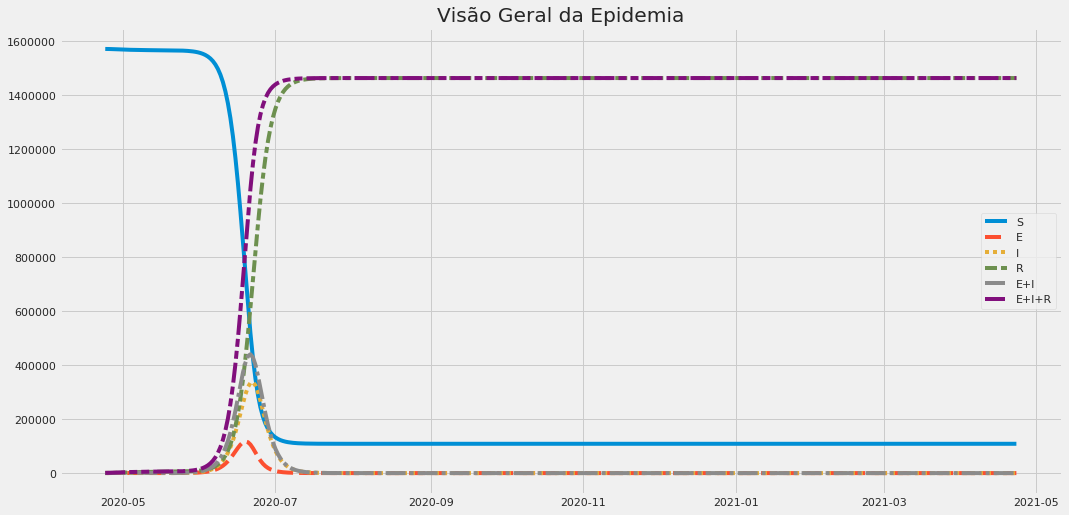

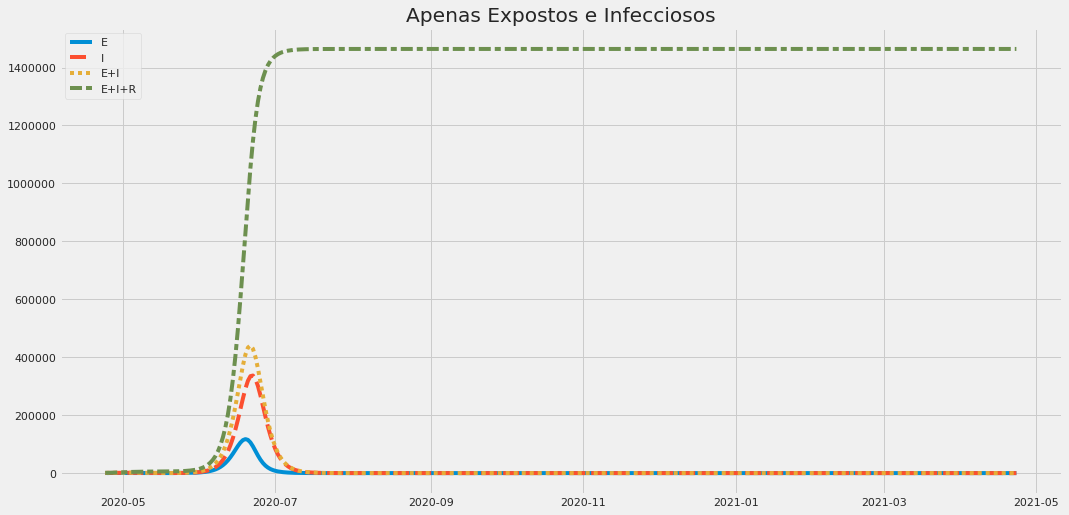

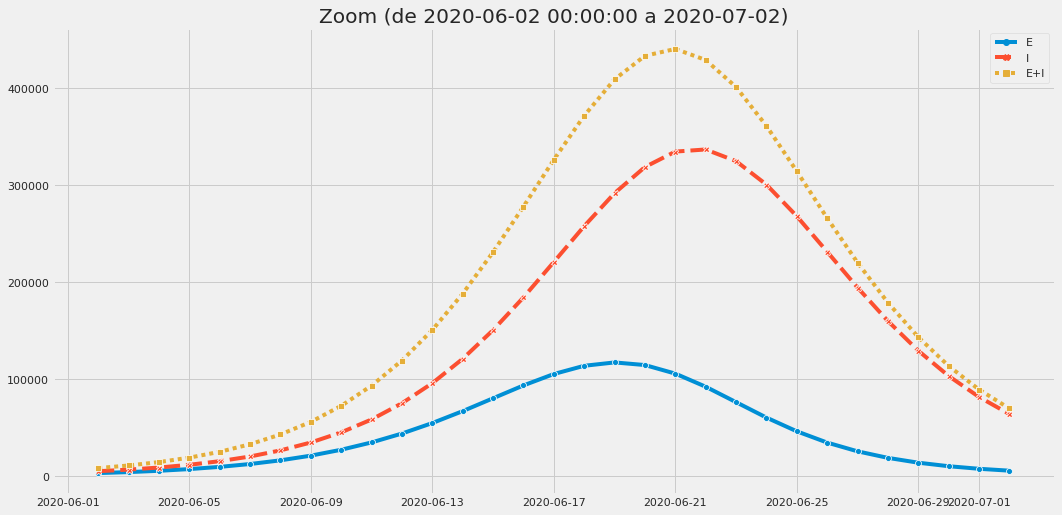

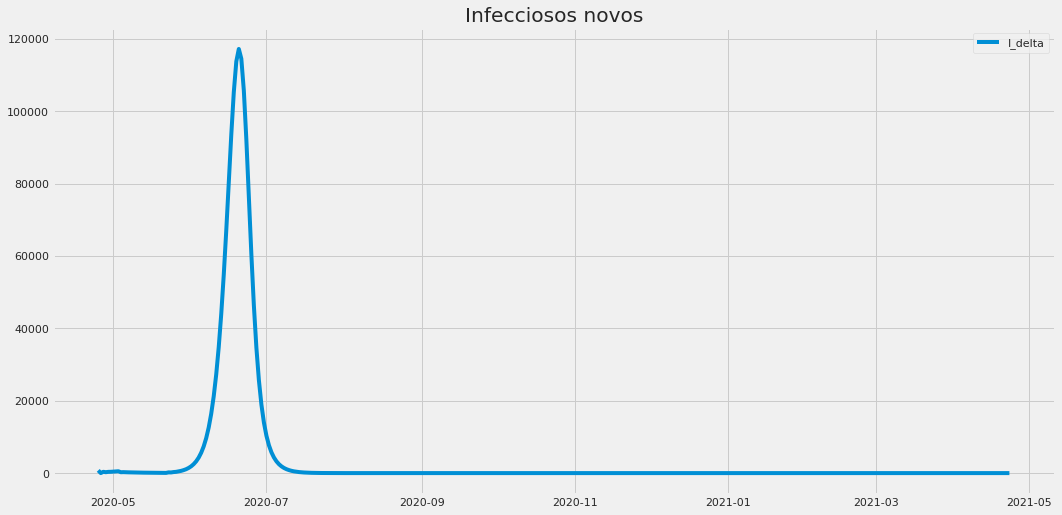

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

2.7008859293653877

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

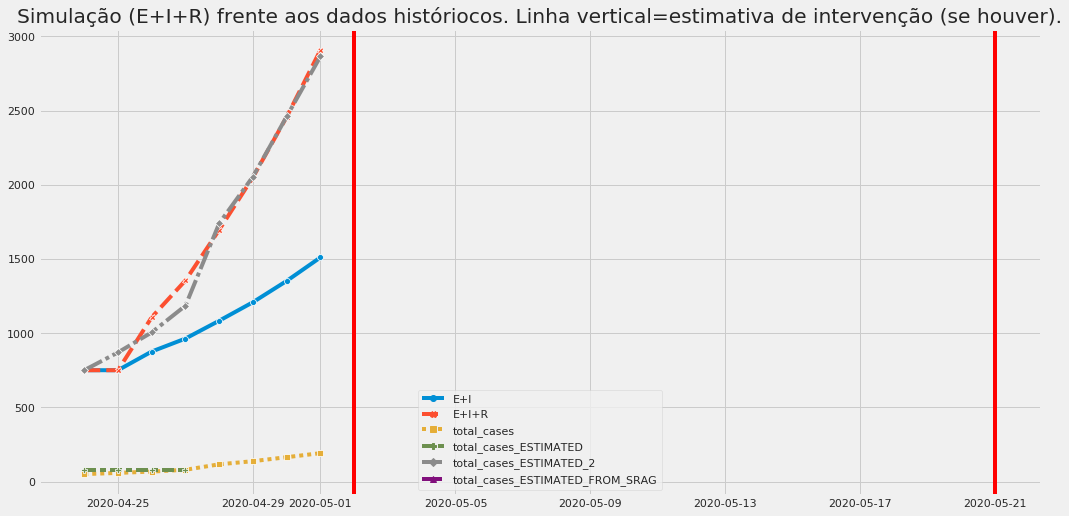

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

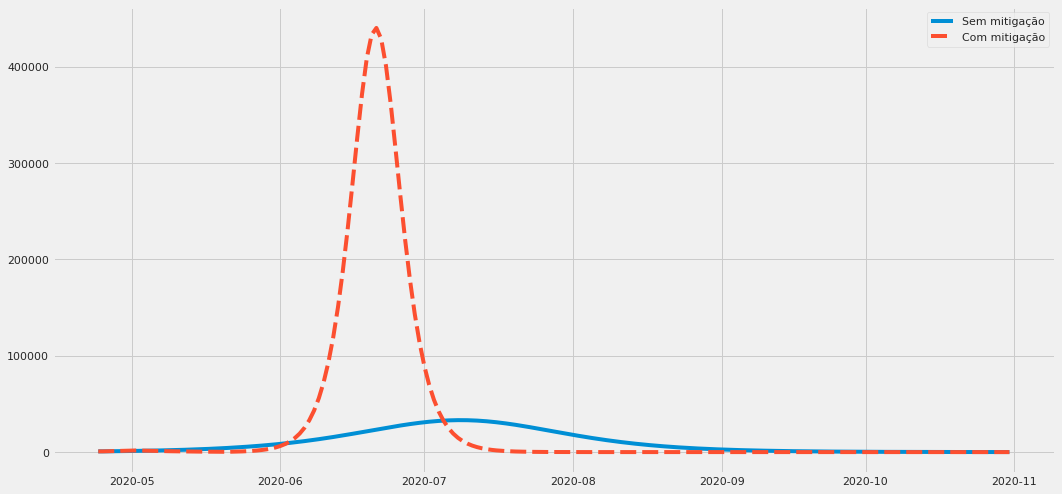

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

11

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.